# Script: Main
Author: Alyde Bles  
Student Number: 2826862  
Date: 31/12/2024

In this notebook, the main analysis is performed. The steps include executing the Multi-Taper Method, defining the Unobserved Components Model, testing different explanatory variables, and checking the assumptions. Forecasts are then made, including full forecasts, seasonal dependence, bias tests, and individual forecasts. Lastly, visualisations are included to summarise the results.

Table of Contents

1. [Packages and Import Data](#Packages-and-Import-Data)  
   Import all required packages and load the datasets.  

2. [Multi-Taper Method](#Multi-Taper-Method)  
   MTM is applied to compare Niño 3.4 absolute temperatures with the Niño 3.4 index.  

3. [UCM Model and Kalman Filter](#UCM-Model-and-Kalman-Filter)  
   - 3.1 [UCM Specifications](#UCM-Specifications)  
     The Unobserved Components Model is defined.  
   - 3.2 [Kalman Filter](#Kalman-Filter)  
     Implementing the Kalman filter equations.  

4. [Testing Explanatory Variables](#Testing-Explanatory-Variables)  
   - 4.1 [Testing Variables](#Testing-Variables)  
     Testing the contribution of different explanatory variables.  
   - 4.2 [Final Explanatory Dataset](#Final-Explanatory-Dataset)  
     Constructing the final explanatory dataset. 

5. [Forecasting](#Forecasting)  
   - 5.1 [Full Model Forecasts](#Full-Model-Forecasts)  
     Generating forecasts using the full model.  
   - 5.2 [Seasonal Dependence Forecasts](#Seasonal-Dependence-Forecasts)  
     Investigating the influence of seasonal dependence.  
   - 5.3 [Bias Testing and Scatterplots](#Bias-Testing-and-Scatterplots)  
     Testing forecast bias and visualising scatterplots.  
   - 5.4 [Event Functions](#Event-Functions)  
     Forecasting specific events.  

6. [Assumptions](#Assumptions)  
   - 6.1 [Assumptions for Main Model](#Assumptions-for-Main-Model)  
     Testing assumptions for the main model.  
   - 6.2 [Assumptions with Seasonality](#Assumptions-with-Seasonality)  
     Testing assumptions with the model with seasonality 

7. [Visualisations](#Visualisations)  
   - 7.1 [Different Cycles plotted](#Different-cycles-plotted)  
     Generate plots for the different cycles estimated
   - 7.1 [General Forecast Plots](#Different-Periods)  
     Generate plots for all lead times and sub-period comparisons.
   - 7.2 [Seasonal Dependence Plots](#Seasonal-Dependence-Plots)  
    Visualise seasonal dependence for target months and initialisation months.  
   - 7.3 [Event Plots](#Event-Plots)  
     Show visualisations for forecasted events.  

# Packages and Import Data

In [2]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import describe
from scipy import signal

from scipy.signal import find_peaks
from mne.time_frequency import psd_array_multitaper

from scipy.stats import chi2, f, probplot
from statsmodels.stats.diagnostic import acorr_ljungbox

from scipy.ndimage import gaussian_filter1d
import matplotlib.cm as cm
from scipy.stats import skew


In [3]:
nino_34_anom_path = 'Data/Data Process/nino_34_sst_anomalies.csv'
nino_34_aboslute_path = 'Data/Data Process/nino_34_sst.csv'


new_nino = pd.read_csv(nino_34_anom_path)
# Rename the 'time' column to 'Date'
new_nino.rename(columns={'time': 'Date'}, inplace=True)
new_nino['Date'] = pd.to_datetime(new_nino['Date'])
new_nino_filtered = new_nino[(new_nino['Date'] >= '1950-01-01') & (new_nino['Date'] <= '2023-12-31')].reset_index(drop=True)
new_nino_filtered.rename(columns={'nino_34_anomaly': 'Enso'}, inplace=True)

nino_34_absolute = pd.read_csv(nino_34_aboslute_path)
# Rename the 'time' column to 'Date'
nino_34_absolute.rename(columns={'time': 'Date'}, inplace=True)
nino_34_absolute['Date'] = pd.to_datetime(new_nino['Date'])
nino_34_absolute = nino_34_absolute[nino_34_absolute['Date'] >= '1950-01-01']
nino_34_absolute.rename(columns={'nino_34_sst': 'Enso'}, inplace=True)

data_final = new_nino_filtered





In [4]:
# Define the directory containing the files
input_directory = "Data/Data Top/"

# Dictionary to hold dataframes
dataframes_top = {}

# Process each file in the directory
for file_name in os.listdir(input_directory):
    if file_name.endswith(".csv"):
        file_path = os.path.join(input_directory, file_name)
        
        try:
            # Load the dataset
            df = pd.read_csv(file_path)
            
            # Check for a 'time' or 'Date' column and convert to datetime
            if 'time' in df.columns:
                df.rename(columns={'time': 'Date'}, inplace=True)
            elif 'Date' not in df.columns:
                print(f"Skipping file {file_name}: No 'Date' or 'time' column found.")
                continue
            
            df['Date'] = pd.to_datetime(df['Date'])
            df['Date'] = df['Date'].apply(lambda x: x.replace(day=1) if x.day == 16 else x)

            
            # Filter rows starting from 1950-01-01
            filtered_df = df[(df['Date'] >= '1950-01-01') & (df['Date'] <= '2023-12-01')].reset_index(drop=True)
            
            # Set values greater than 1 million to 0
            filtered_df.iloc[:, 1:] = filtered_df.iloc[:, 1:].apply(
                lambda col: col.map(lambda x: 0 if x > 1_000_000 else x)
            )
            
            # Store in dictionary with file name as key
            dataframes_top[file_name] = filtered_df
            print(f"Loaded, filtered, and cleaned: {file_name}")
        
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

# Example: Access a specific dataframe to verify cleaning
example_file = list(dataframes_top.keys())[0]
print(dataframes_top[example_file].head())

Loaded, filtered, and cleaned: top_20_regions_averages_lag_5_z20.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_17_sst.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_22_z20.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_14_z20.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_16_ws.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_21_sst.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_20_ws.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_5_ws.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_6_sst.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_9_ws.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_15_z20.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_14_ws.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_20_sst.csv
Loaded, filtered, and cleaned: top_20_regions_averages_lag_18_ws.csv
Loaded, filtered, and cleaned:

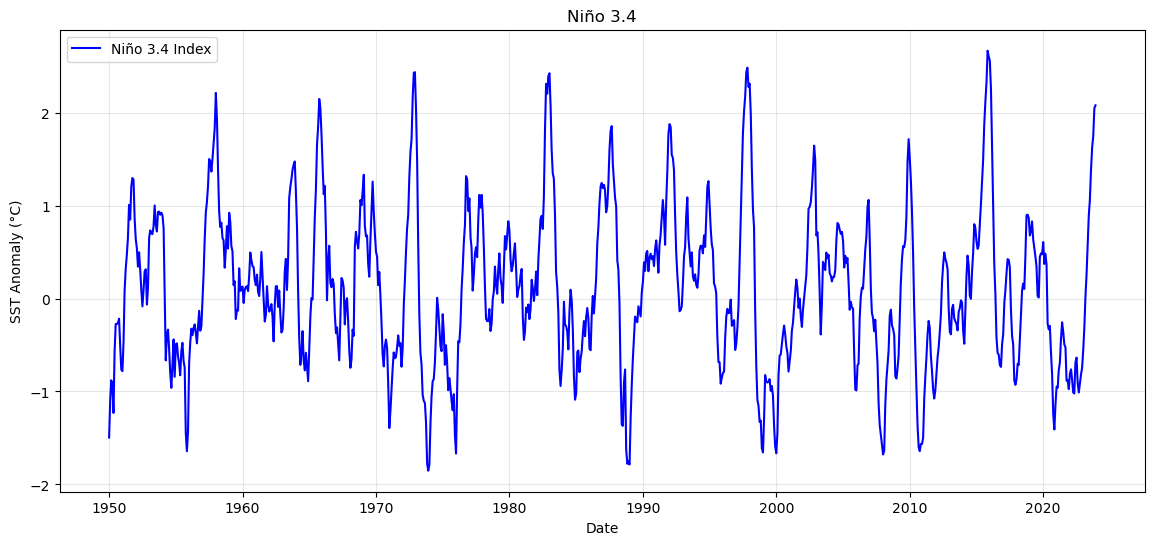

In [5]:
# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Plot new_nino data
plt.subplot(1, 1, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(data_final['Date'], data_final['Enso'], label='Niño 3.4 Index', color='blue')
plt.title('Niño 3.4')
plt.xlabel('Date')
plt.ylabel('SST Anomaly (°C)')
plt.grid(alpha=0.3)
plt.savefig('Figures/Nino_34_index_plot.pdf', format = "pdf", bbox_inches ="tight")
plt.legend()


# Multi Taper Method

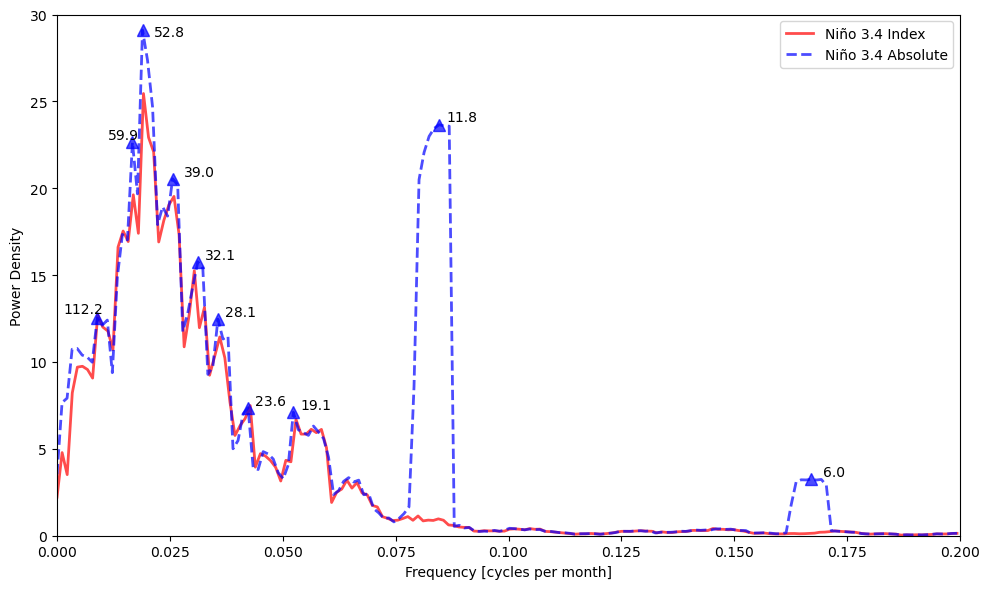

In [6]:
# Define input series for anomalies and absolute temperatures
nino34_series_anom = new_nino_filtered['Enso']
nino34_series_absolute = nino_34_absolute['Enso']
sfreq = 1  # Sampling frequency in cycles per month

# Perform multitaper spectral analysis for anomalies
psd_anom, freqs_anom = psd_array_multitaper(nino34_series_anom, sfreq=sfreq, adaptive=True, normalization='full', verbose=0)

# Filter frequencies up to 0.2 cycles per month for anomalies
freqs_anom_filtered = freqs_anom[freqs_anom <= 0.2]
psd_anom_filtered = psd_anom[:len(freqs_anom_filtered)]

# Perform multitaper spectral analysis for absolute temperatures
psd_abs, freqs_abs = psd_array_multitaper(nino34_series_absolute, sfreq=sfreq, adaptive=True, normalization='full', verbose=0)

# Identify prominent peaks based on prominence for absolute temperatures
prominent_peaks_abs, _ = find_peaks(psd_abs, prominence=2)

# Filter frequencies up to 0.2 cycles per month for absolute
freqs_abs_filtered = freqs_abs[freqs_abs <= 0.2]
psd_abs_filtered = psd_abs[:len(freqs_abs_filtered)]
prominent_peaks_abs_filtered = [peak for peak in prominent_peaks_abs if freqs_abs[peak] <= 0.2]

# Define specific label offsets for the absolute temperature peaks
label_offsets = {
    prominent_peaks_abs_filtered[0]: (-0.003, 0.1),
    prominent_peaks_abs_filtered[1]: (-0.002, 0),
    prominent_peaks_abs_filtered[2]: (0.006, -0.5),
    prominent_peaks_abs_filtered[3]: (0.006, 0),
    prominent_peaks_abs_filtered[4]: (0.005, 0),
    prominent_peaks_abs_filtered[5]: (0.005, 0),
    prominent_peaks_abs_filtered[6]: (0.005, 0),
    prominent_peaks_abs_filtered[7]: (0.005, 0),
    prominent_peaks_abs_filtered[8]: (0.005, 0.02),
    prominent_peaks_abs_filtered[9]: (0.005, 0.02),
}

# Helper function to convert frequencies to months per cycle
def frequency_to_period(freq):
    return 1 / freq if freq > 0 else np.inf

# Plot both anomalies and absolute temperatures PSD on the same figure
plt.figure(figsize=(10, 6))

# Plot anomalies PSD with a solid line and slightly transparent
plt.plot(freqs_anom_filtered, psd_anom_filtered, label='Niño 3.4 Index', color='red', linestyle='-', linewidth=2, alpha=0.7)

# Plot absolute temperatures PSD with a dashed line and slightly transparent
plt.plot(freqs_abs_filtered, psd_abs_filtered, label='Niño 3.4 Absolute', color='blue', linestyle='--', linewidth=2, alpha=0.7)

# Label peaks for absolute temperatures with period (months per cycle)
for i, peak in enumerate(prominent_peaks_abs_filtered):
    freq_peak = freqs_abs[peak]
    psd_peak = psd_abs[peak]
    period_peak = frequency_to_period(freq_peak)  # Convert frequency to period (months per cycle)
    plt.plot(freq_peak, psd_peak, 'b^', markersize=8, alpha=0.7)  # Mark peak with a blue triangle
    # Use label offsets for precise placement
    offset_x, offset_y = label_offsets.get(peak, (0, 0))
    plt.text(freq_peak + offset_x, psd_peak + offset_y, f'{period_peak:.1f}', color='black', fontsize=10, ha='center', va='bottom')

# Set axis labels, title, and legend

plt.xlabel('Frequency [cycles per month]')
plt.ylabel('Power Density')
plt.legend()
plt.xlim([0, 0.2])  # Limit x-axis to show only up to 0.2 cycles per month
plt.ylim(bottom=0, top=30)  # Adjust y-axis as needed
plt.grid(False)
plt.tight_layout()

# Save the combined figure
plt.savefig('Figures/Multi_Taper_Method_Combined.pdf')
plt.show()


# UCM Model and Kalman Filter  

## UCM Specifications

In [7]:
# --------------------------------------
# Helper Functions
# --------------------------------------

def sigma_l(a_l):
    """Applies exponential transformation to ensure positive values for sigma."""
    return np.exp(a_l)

def phi_psi_j(b_psi_j, use_damping=True):
    """Constrains damping factors to a reasonable range (e.g., 0.8 to 1.0)."""
    raw_value = np.exp(b_psi_j) / (1 + np.exp(b_psi_j)) if use_damping else 1
    return raw_value

def lambda_c_j(d_j):
    """Ensures cycle frequencies lie between 0 and 2pi."""
    return 2 * np.pi / (1 + np.exp(d_j))  # Adjusted transformation for distinct frequencies

def c_s_j(j, phi_psi, lambda_c):
    """Calculates cosine and sine components for cycle j, ensuring real values."""
    c_j = np.cos(lambda_c[j].real) * phi_psi[j].real
    s_j = np.sin(lambda_c[j].real) * phi_psi[j].real
    return c_j, s_j

def bounded_lambda_j(d_j, lower_bound=0, upper_bound=1):
    """Ensures that the cycle frequency lies between lower_bound and upper_bound."""
    scaled_value = 2 * np.pi / (1 + np.exp(d_j))  # Sigmoid transformation to constrain between 0 and 2pi
    return lower_bound + scaled_value * (upper_bound - lower_bound)

# --------------------------------------


In [8]:
# --------------------------------------
# Functions for State-Space Model Matrices
# --------------------------------------

def define_T(k, phi_psi=None, lambda_c=None, model_type=1):
    """
    Defines the T_t transition matrix for different state-space models.

    Parameters:
    - k: Number of exogenous variables.
    - phi_psi: List of damping factors for cycles.
    - lambda_c: List of cycle frequencies.
    - model_type: Specifies the type of model (1 is the main model, 2 is an alternative model).

    Returns:
    - T_t matrix.
    """
    if model_type == 1:  # Main model
        T = np.zeros((7 + k, 7 + k))

        # Trend component (level only, no slope)
        T[0, 0] = 1
        # Cycle components
        for i in range(3):
            c, s = np.cos(lambda_c[i]).real, np.sin(lambda_c[i]).real
            T[1 + i * 2, 1 + i * 2] = (c * phi_psi[i]).real
            T[1 + i * 2, 1 + i * 2 + 1] = (s * phi_psi[i]).real
            T[1 + i * 2 + 1, 1 + i * 2] = (-s * phi_psi[i]).real
            T[1 + i * 2 + 1, 1 + i * 2 + 1] = (c * phi_psi[i]).real

        # Identity matrix for exogenous variables
        T[7:, 7:] = np.eye(k)

        return T

    elif model_type == 2:  # Alternative model
        T = np.zeros((18 + k, 18 + k))
        S = 12
        lambdas = [(2 * np.pi * i) / S for i in range(1, S // 2)]

        # Cosine and sine components for predefined lambda values
        p = [np.cos(lam).real for lam in lambdas]
        q = [np.sin(lam).real for lam in lambdas]

        # Set seasonal components
        seasonal_scale = 1
        T[0, 0] = 1
        for i in range(5):  # Populate seasonal cycles
            T[2 * i + 1, 2 * i + 1], T[2 * i + 1, 2 * i + 2] = seasonal_scale * p[i], seasonal_scale * q[i]
            T[2 * i + 2, 2 * i + 1], T[2 * i + 2, 2 * i + 2] = -seasonal_scale * q[i], seasonal_scale * p[i]
        T[11, 11] = -1

        # Cycle components
        for j in range(3):
            c, s = c_s_j(j, phi_psi, lambda_c)
            T[12 + 2 * j, 12 + 2 * j], T[12 + 2 * j, 12 + 2 * j + 1] = c.real, s.real
            T[12 + 2 * j + 1, 12 + 2 * j], T[12 + 2 * j + 1, 12 + 2 * j + 1] = -s.real, c.real

        # Identity matrix for exogenous variables
        T[18:, 18:] = np.eye(k)

        return T

    else:
        raise ValueError("Invalid model type specified.")


def define_Z(t, k, exog=None, model_type=1):
    """
    Defines the Z_t observation matrix for different state-space models.

    Parameters:
    - t: Time index for observation.
    - k: Number of exogenous variables.
    - exog: DataFrame containing exogenous variables.
    - model_type: Specifies the type of model (1 is the main model, 2 is an alternative model).

    Returns:
    - Z_t matrix (1xN).
    """
    if model_type == 1:  # Main model
        Z_t = np.zeros(7 + k)
        Z_t[:7] = [1, 1, 0, 1, 0, 1, 0]
    elif model_type == 2:  # Alternative model
        Z_t = np.zeros(18 + k)
        Z_t[:18] = [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]
    else:
        raise ValueError("Invalid model type specified.")

    # Add exogenous variables if provided
    if exog is not None:
        i = len(Z_t) - k  # Start position for exogenous variables in Z_t
        for var_name in exog.columns:
            Z_t[i] = exog[var_name].iloc[t] if 0 <= t < len(exog) else 0  # Add value or zero if out of bounds
            i += 1

    return Z_t.reshape(1, -1)  # Ensure it is 2D


def define_G(sigma_epsilon, model_type=1):
    """
    Defines the G_t observation noise covariance matrix.

    Parameters:
    - sigma_epsilon: Observation noise variance.
    - model_type: Specifies the type of model (1 is the main model, 2 is an alternative model).

    Returns:
    - G_t matrix.
    """
    if model_type in {1, 2}:
        return np.array([[sigma_epsilon]])
    else:
        raise ValueError("Invalid model type specified.")


def define_H(k, sigma_eta, sigma_omega=None, sigma_kappa1=None, sigma_kappa2=None, sigma_kappa3=None, model_type=1):
    """
    Defines the H_t process noise covariance matrix.

    Parameters:
    - k: Number of exogenous variables.
    - sigma_eta: Variance for the trend component.
    - sigma_omega: Variance for the seasonal component.
    - sigma_kappa1, sigma_kappa2, sigma_kappa3: Variances for cycle components.
    - model_type: Specifies the type of model (1 is the main model, 2 is an alternative model).

    Returns:
    - H_t matrix.
    """
    if model_type == 1:  # Main model
        H = np.zeros((7 + k, 7))
        H[0, 0] = sigma_eta.real  # Trend variance
        H[1, 1], H[2, 2] = sigma_kappa1.real, sigma_kappa1.real
        H[3, 3], H[4, 4] = sigma_kappa2.real, sigma_kappa2.real
        H[5, 5], H[6, 6] = sigma_kappa3.real, sigma_kappa3.real

    elif model_type == 2:  # Alternative model
        H = np.zeros((18 + k, 8))
        H[0, 0] = sigma_eta.real
        H[1, 1] = sigma_omega.real
        H[12, 2], H[13, 3] = sigma_kappa1.real, sigma_kappa1.real
        H[14, 4], H[15, 5] = sigma_kappa2.real, sigma_kappa2.real
        H[16, 6], H[17, 7] = sigma_kappa3.real, sigma_kappa3.real

    else:
        raise ValueError("Invalid model type specified.")

    return H


In [9]:
# --------------------------------------
# Parameter Transformation Functions
# --------------------------------------

def transform_fitted_params(params, use_damping=True, model_type=1):
    """
    Transforms fitted parameters based on the model type and returns a dictionary of transformed parameters.

    Parameters:
    - params: List of fitted parameters to transform.
    - use_damping: Whether to apply damping to cycle components (default is True).
    - model_type: Specifies the type of model (1 is the main model, 2 includes seasonal components).

    Returns:
    - Dictionary containing transformed parameters.
    """
    if model_type == 1:  # Main model
        # Parameters for Model 1
        a_e, a_eta, a_kappa1, a_kappa2, a_kappa3, b_psi1, b_psi2, b_psi3, d1, d2, d3 = params
        transformed_params = {
            "σ_ε": sigma_l(a_e),  # Observation noise
            "σ_η": sigma_l(a_eta),  # Trend noise
            "σ_κ1": sigma_l(a_kappa1),  # Cycle 1 noise
            "σ_κ2": sigma_l(a_kappa2),  # Cycle 2 noise
            "σ_κ3": sigma_l(a_kappa3),  # Cycle 3 noise
            "φ_ψ1": phi_psi_j(b_psi1, use_damping),  # Damping for Cycle 1
            "φ_ψ2": phi_psi_j(b_psi2, use_damping),  # Damping for Cycle 2
            "φ_ψ3": phi_psi_j(b_psi3, use_damping),  # Damping for Cycle 3
            "λ_c1": lambda_c_j(d1),  # Frequency for Cycle 1
            "λ_c2": lambda_c_j(d2),  # Frequency for Cycle 2
            "λ_c3": lambda_c_j(d3)   # Frequency for Cycle 3
        }

    elif model_type == 2:  # Model with seasonal components
        # Parameters for Model 2
        a_e, a_eta, a_omega, a_kappa1, a_kappa2, a_kappa3, b_psi1, b_psi2, b_psi3, d1, d2, d3 = params
        transformed_params = {
            "σ_ε": sigma_l(a_e),  # Observation noise
            "σ_η": sigma_l(a_eta),  # Trend noise
            "σ_ω": sigma_l(a_omega),  # Seasonal noise
            "σ_κ1": sigma_l(a_kappa1),  # Cycle 1 noise
            "σ_κ2": sigma_l(a_kappa2),  # Cycle 2 noise
            "σ_κ3": sigma_l(a_kappa3),  # Cycle 3 noise
            "φ_ψ1": phi_psi_j(b_psi1, use_damping),  # Damping for Cycle 1
            "φ_ψ2": phi_psi_j(b_psi2, use_damping),  # Damping for Cycle 2
            "φ_ψ3": phi_psi_j(b_psi3, use_damping),  # Damping for Cycle 3
            "λ_c1": lambda_c_j(d1),  # Frequency for Cycle 1
            "λ_c2": lambda_c_j(d2),  # Frequency for Cycle 2
            "λ_c3": lambda_c_j(d3)   # Frequency for Cycle 3
        }
    else:
        raise ValueError("Invalid model_type. Choose between 1 or 2.")

    return transformed_params




In [10]:
class CustomStateSpaceModel(sm.tsa.statespace.MLEModel):
    """
    Custom State-Space Model for different model types.

    Parameters:
    - y_t: The endogenous variable (observed time series).
    - x_t: Exogenous variables (optional).
    - k: Number of exogenous variables (default is 0).
    - params: Initial parameter values (optional).
    - use_damping: Whether to include damping in cycles (default is True).
    - init_type: Method for initializing state variables ('diffuse', 'known', 'fixed', 'empirical').
    - a0_custom: Custom initial state vector (optional).
    - model_type: Specifies the type of model (1 is the main model, 2 is an alternative model).
    """

    def __init__(self, y_t, x_t=None, k=0, params=None, use_damping=True, init_type="diffuse", a0_custom=None, model_type=1):
        # Combine exogenous variables into a single array if provided
        exog = np.c_[x_t] if x_t is not None else None
        nobs = len(y_t)  # Number of observations
        num_exog = exog.shape[1] if exog is not None else 0  # Number of exogenous variables

        # Define the number of states (k_states) and the position-definite dimension (k_posdef)
        if model_type == 2:  # Alternative model
            k_states, self.k_posdef = 18 + k, 8
        else:  # Main model
            k_states, self.k_posdef = 7 + k, 7

        # Initialize the MLEModel base class
        super(CustomStateSpaceModel, self).__init__(endog=y_t, exog=exog, k_states=k_states, k_posdef=self.k_posdef)

        # Store parameters and settings
        self.k = k
        self.use_damping = use_damping
        self.params = params
        self.exog = exog
        self.model_type = model_type

        # Define the fixed design matrix for observations
        if model_type == 2:  # Alternative model
            fixed_pattern = np.array([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0])
        else:  # Main model
            fixed_pattern = np.array([1, 1, 0, 1, 0, 1, 0])

        # Create the fixed design matrix for all observations
        fixed_design = np.tile(fixed_pattern, (nobs, 1)).T[np.newaxis, :, :]

        # Add exogenous variables to the design matrix if provided
        if exog is not None:
            exog_design = exog.T[np.newaxis, :, :]
            full_design = np.concatenate([fixed_design, exog_design], axis=1)
        else:
            full_design = fixed_design

        # Assign the observation matrix (Z_t) to the state-space model
        self.ssm["design"] = full_design

        # Initialize state-space matrices
        T, G, H = self._define_state_space_components(k, params, model_type)
        self['state_cov'] = np.eye(self.k_posdef)  # State covariance matrix
        self['transition'] = T  # Transition matrix
        self['obs_cov'] = np.dot(G, G.T)  # Observation noise covariance matrix
        self['selection'] = H

        # Set the initialization method for state variables
        self.initialize_approximate_diffuse()

    @property
    def start_params(self):
        """
        Returns the initial parameter values.
        """
        return self.params

    def update(self, params, transformed=True, includes_fixed=True, complex_step=False):
        """
        Updates the state-space model matrices with new parameters.

        Parameters:
        - params: New parameter values to update.
        """
        T, G, H = self._define_state_space_components(self.k, params, self.model_type)
        self['transition'] = T
        self['selection'] = H
        self['obs_cov'] = np.dot(G, G.T)
        self['state_cov'] = np.eye(self.k_posdef)

    def transform_parameters(self, params):
        """
        Transforms the raw parameters into model-specific values.

        Parameters:
        - params: Raw parameters to transform.

        Returns:
        - Dictionary of transformed parameters.
        """
        return transform_fitted_params(params, use_damping=self.use_damping, model_type=self.model_type)

    def _define_state_space_components(self, k, params, model_type):
        """
        Defines the T, G, and H matrices for the state-space model.

        Parameters:
        - k: Number of exogenous variables.
        - params: Transformed parameter values.
        - model_type: Specifies the type of model (1 is the main model, 2 is an alternative model).

        Returns:
        - T: Transition matrix.
        - G: Observation noise matrix.
        - H: Process noise covariance matrix.
        """
        transformed_params = self.transform_parameters(params)

        # Extract parameters
        sigma_e = transformed_params["σ_ε"]  # Observation noise
        sigma_eta = transformed_params["σ_η"]  # Trend noise
        sigma_omega = transformed_params.get("σ_ω", None)  # Seasonal noise (only for model_type=2)
        sigma_kappa1 = transformed_params["σ_κ1"]  # Cycle 1 noise
        sigma_kappa2 = transformed_params["σ_κ2"]  # Cycle 2 noise
        sigma_kappa3 = transformed_params["σ_κ3"]  # Cycle 3 noise
        phi_psi = [
            transformed_params["φ_ψ1"],
            transformed_params["φ_ψ2"],
            transformed_params["φ_ψ3"]
        ]  # Cycle damping factors
        lambda_c = [
            transformed_params["λ_c1"],
            transformed_params["λ_c2"],
            transformed_params["λ_c3"]
        ]  # Cycle frequencies

        # Define the state-space matrices
        T = define_T(k, phi_psi, lambda_c, model_type=model_type)  # Transition matrix
        G = define_G(sigma_e, model_type=model_type)  # Observation noise matrix
        H = define_H(
            k, sigma_eta, sigma_omega=sigma_omega,
            sigma_kappa1=sigma_kappa1, sigma_kappa2=sigma_kappa2, sigma_kappa3=sigma_kappa3,
            model_type=model_type
        )  # Process noise covariance matrix

        return T, G, H


   

In [11]:
# Define the target variable and the lag structure
yt = data_final['Enso']
yt_new = yt[:525]

bounds_4 = [
    (None, None),  # σ_ε
    (None, None),  # σ_η
    (None, None),  # σ_κ1
    (None, None),  # σ_κ2
    (None, None),  # σ_κ3
    (2.18, None), # φ_ψ1
    (2.18, None), # φ_ψ2
    (2.18, None),  # φ_ψ3
    (3.85, 4.23), # λ_c1 (Frequency for cycle 1)
    (3.14, 3.71), # λ_c2 (Frequency for cycle 2)
    (2.38, 2.89), # λ_c3 (Frequency for cycle 3)
]
# Define initial parameters for model type 4
initial_params_4 = [0.1, 0.1, 0.1, 0.1, 0.1, 4.5, 3.0, 2.9, 2.5, 2.1, 2.6]

# Define a function to create, fit, and extract information from the model
def fit_and_evaluate_model_4(yt, xt_values, initial_params, k, bounds):
    print("\n=== Fitting Model Type 4 ===")
    
    # Initialize the model
    model = CustomStateSpaceModel(
        yt,
        xt_values,
        k=k,
        params=initial_params,
        use_damping=True,
    )
    
    # Fit the model
    model_fit = model.fit(start_params=initial_params, disp=False, maxiter=1000000, bounds = bounds)
    filtered_states = model_fit.filtered_state
    
    # Get and transform the fitted parameters
    transformed_params = transform_fitted_params(model_fit.params, use_damping=True)
    
    # Print the transformed parameters with labels
    print("Transformed Parameters:")
    for name, value in transformed_params.items():
        print(f"{name}: {value:.4f}")  
         
    return model_fit, transformed_params, model, filtered_states, model_fit.params 

# Fit and evaluate the model
model_fit_4, transformed_params_4, model, filtered_sates, untransformed_params = fit_and_evaluate_model_4(
    yt, None, initial_params_4, k=0, bounds= bounds_4
)



=== Fitting Model Type 4 ===


Transformed Parameters:
σ_ε: 0.0010
σ_η: 0.0032
σ_κ1: 0.1399
σ_κ2: 0.1041
σ_κ3: 0.1101
φ_ψ1: 0.9747
φ_ψ2: 0.9697
φ_ψ3: 0.9474
λ_c1: 0.1088
λ_c2: 0.1978
λ_c3: 0.3465


## Kalman Filter

In [12]:
#### additional kalman fitler for the sake of forecasting. Get not get it out the whole model. 
def kalman_filter(k, y, T, G, H, a0, P0, exog):
    """
    Implements Kalman filter recursions for a state-space model.

    Parameters:
    - y: Array of observations (endog).
    - T: State transition matrix.
    - G: Observation noise covariance matrix.
    - H: State noise selection matrix.
    - Z_func: Function to compute Z_t (design matrix) dynamically.
    - a0: Initial state vector.
    - P0: Initial covariance matrix.
    - exog: Array of exogenous variables.

    Returns:
    - a: Array of filtered state estimates (shape: [n_states, n_obs]).
    - P: Array of state covariance matrices (shape: [n_obs, n_states, n_states]).
    - v: Array of innovations (residuals) (shape: [n_obs]).
    - F: Array of innovation covariances (shape: [n_obs]).
    - K: Array of Kalman gain matrices (shape: [n_obs, n_states]).
    """
    n_obs = len(y)
    k_states = len(a0)
    k_posdef = H.shape[1]  # Number of columns in the H matrix

    # Initialize outputs
    a = np.zeros((k_states, n_obs))  # Filtered state estimates
    P = np.zeros((n_obs, k_states, k_states))  # Covariance of state estimates
    v = np.zeros(n_obs)  # Innovations (residuals)
    F = np.zeros(n_obs)  # Innovation covariance
    K = np.zeros((n_obs, k_states))  # Kalman gain
    Q = np.eye(k_posdef)

    # Initialize state and covariance
    current_a = a0
    current_P = P0
    Z_matrices = np.zeros((n_obs, k_states))  # Array to store all design matrices


    # Iterate over each observation
    for t in range(n_obs):
        if not np.isnan(y[t]):
            # Compute Z_t dynamically
            Z_t = define_Z(t, k, exog=exog)
            Z_matrices[t, :] = Z_t  # Store the design matrix
                        # Prediction step: Use previous state for prediction
            if t == 0:
                predicted_a = current_a  # For the first time step, use initial state
            else:
                predicted_a = np.dot(T, a[:, t-1])  # Predicted state from previous state (a[t-1])

            # Prediction step
            #predicted_a = np.dot(T, current_a)  # Predicted state
            predicted_P = np.dot(np.dot(T, current_P), T.T) + np.dot(np.dot(H, Q), H.T)  # Predicted covariance

            # Innovation (residual)
            y_pred = np.dot(Z_t, predicted_a)  # Predicted observation
            innovation = y[t] - y_pred  # Difference between actual and predicted
            innovation_cov = np.dot(np.dot(Z_t, predicted_P), Z_t.T) + G @ G.T  # Innovation covariance

            # Kalman gain
            K_t = np.dot(np.dot(predicted_P, Z_t.T), np.linalg.inv(innovation_cov))
            K[t] = K_t.flatten()  # Convert (8, 1) into (8,)

            # Update step
            current_a = predicted_a + np.dot(K_t, innovation)  # Updated state
            current_P = predicted_P - np.dot(np.dot(K_t, Z_t), predicted_P)  # Updated covariance

            # Store results
            a[:, t] = current_a
            P[t] = current_P
            v[t] = innovation.item()
            F[t] = innovation_cov.item()
        else: 
            
            if t == 0:
                current_a = a0  # At t=0, use the initial state (a0)
            else:
                current_a = np.dot(T, a[:, t-1])  # Use previous state to forecast (a[t-1])

            a[:, t] = current_a  # Store forecasted state

    return a, P, v, F, Z_matrices

In [13]:
def define_state_space_components(params, k, model_type =1):
    """
    Defines the state-space components (T, G, H, a0, P0) based on the provided parameters.

    Parameters:
    - params: List of fitted parameters for model type 4.
    - k: Number of exogenous variables.

    Returns:
    - T: State transition matrix.
    - G: Measurement noise covariance matrix.
    - H: Process noise covariance matrix.
    - a0: Initial state vector.
    - P0: Initial covariance matrix.
    """
    # Transform the parameters
    transformed_params = transform_fitted_params(params,model_type = model_type)

    # Extract parameters for model type 4
    sigma_e = transformed_params["σ_ε"]

    sigma_omega = transformed_params.get("σ_ω", None)  # Seasonal noise (only for model_type=2)

    sigma_eta = transformed_params["σ_η"]
    sigma_kappa1 = transformed_params["σ_κ1"]
    sigma_kappa2 = transformed_params["σ_κ2"]
    sigma_kappa3 = transformed_params["σ_κ3"]
    
    phi_psi = [
        transformed_params["φ_ψ1"],
        transformed_params["φ_ψ2"],
        transformed_params["φ_ψ3"]
    ]
    lambda_c = [
        transformed_params["λ_c1"],
        transformed_params["λ_c2"],
        transformed_params["λ_c3"]
    ]
  
    # Define matrices using the extracted parameters
    T = define_T(k, phi_psi, lambda_c)
    G = define_G(sigma_e)
    H = define_H(k, sigma_eta, sigma_omega = sigma_omega, sigma_kappa1=sigma_kappa1, sigma_kappa2=sigma_kappa2, sigma_kappa3=sigma_kappa3)

    # Define initial state vector and covariance matrix
    k_states = T.shape[0]
    
    a0 = np.zeros(k_states) *0.1
    a0[k_states-1] = 5.0 
    P0 = np.eye(k_states) * 10e2

    return T, G, H, a0, P0

In [14]:
# Example usage of the function
yt = data_final['Enso']  # Example observed data (endogenous variable)
k =0
# Assuming params are from some model fitting process
params = model_fit_4.params  # Example of fitted parameters from your model

# Call the function to get state-space components
T, G, H, a0, P0 = define_state_space_components(params, k)

# Now, you can use these components in your Kalman filter
a, P, v, F, Z_matrices = kalman_filter(k, yt, T, G, H, a0, P0, None)
a[:,-1]

array([ 0.09712046,  1.19610586,  0.32382703,  0.53889507,  0.11252646,
        0.2461227 , -0.07393961])

## Testing Explanatory Variables

### Testing Variables

In [14]:
"""

Functions to construct lagged series of explanatory variables.

These functions are designed to create lagged versions of single or multiple columns in a DataFrame. 
The lagged series can also be extended by appending the last lag rows from the original data for continuity.
"""

import pandas as pd

def create_lagged_series_with_extension(data, column_name, lag):
    """
    Creates a lagged series for a specified column and appends the last lag values from the original series.

    Parameters:
    - data: DataFrame containing the data.
    - column_name: Name of the column to lag.
    - lag: Number of lagged rows.

    Returns:
    - A Series with lagged values and extended final rows.
    """
    # Check if the column exists in the DataFrame
    if column_name not in data.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Create the lagged series and append the last lag rows
    lagged_extended = pd.concat(
        [data[[column_name]].shift(lag, fill_value=0), data[[column_name]].iloc[-lag:]],
        ignore_index=True
    )
    return lagged_extended


def create_lagged_series_with_extension_multiple(data, column_names, lag):
    """
    Creates lagged series for multiple columns and appends the last lag rows from the original data.

    Parameters:
    - data: DataFrame containing the data.
    - column_names: List of column names to lag.
    - lag: Number of lagged rows.

    Returns:
    - DataFrame with lagged values and extended final rows for each column.
    """
    # Check if all columns exist in the DataFrame
    if not all(col in data.columns for col in column_names):
        missing = [col for col in column_names if col not in data.columns]
        raise ValueError(f"Columns {missing} do not exist in the DataFrame.")

    # Initialize an empty DataFrame to store the results
    lagged_extended = pd.DataFrame()

    for column in column_names:
        # Create a lagged series for each column and append the last lag rows
        lagged = pd.concat(
            [data[[column]].shift(lag, fill_value=0), data[[column]].iloc[-lag:]],
            ignore_index=True
        )
        # Add the lagged series to the result DataFrame
        lagged_extended[column] = lagged.squeeze()

    return lagged_extended



In [15]:
# NOTE: This script involves lengthy computations. 

#### this code takes 30 minutes so have it also saved as an csv file! The block under this code is that. 
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def fit_and_forecast_extended(yt, dataset_dict, lags, training_end_idx, k):
    """
    Fit the model with one dataset, extract parameters, and forecast using all datasets in the dataset dictionary.

    Parameters:
    - yt: Array of observed data (endogenous variable).
    - dataset_dict: Dictionary with dataset names as keys and DataFrames as values.
    - forecast_horizons: List of forecast horizons (lags) to test (e.g., [3, 6, ..., 24]).
    - training_end_idx: Index marking the end of the training data.
    - k: Number of explanatory variables.

    Returns:
    - combined_best_df_new: DataFrame with the best variables and RMSE for each dataset and lag.
    """
    results = []

    # Define and fit the model using MLE
    initial_params_4 = [0.1, 0.1, 0.1, 0.15, 0.2, 4.5, 3.0, 2.9, 2.5, 2.1, 2.6]

    # Iterate over all datasets and forecast horizons
    for lag in lags:
        print(f"forecast_horizon")
        for dataset_name, dataset in dataset_dict.items():
            if f"lag_{lag}_" not in dataset_name:
                continue
            # Identify variable type
            print(f"data_set_name: {dataset_name}")
            variable_name = "unknown"
            if "sst" in dataset_name.lower():
                variable_name = "sst"
            elif "z20" in dataset_name.lower():
                variable_name = "z20"
            elif "ws" in dataset_name.lower():
                variable_name = "ws"

            print(f"\nProcessing variable: {variable_name}, lag: {lag}")

            # Iterate through columns in the dataset to find the best variable
            best_variable = None
            best_rmse = float("inf")

            for variable in dataset.columns:
                k =1
                if variable.lower() == "date":
                    continue
                
                                # Train the model with the current variable
                yt_train = yt[:training_end_idx]
                            # Initialize empty lists for forecasts and actuals
                xt_single = create_lagged_series_with_extension(dataset, variable, lag=lag)
                xt_train = xt_single[:training_end_idx]
                model = CustomStateSpaceModel(
                    yt_train,
                    xt_train,
                    k=k,
                    params=initial_params_4,
                    use_damping=True,
                    )
                model_fit = model.fit(
                    start_params=initial_params_4,
                    disp=False,
                    maxiter=10000,
                    factr=1e7,                    
                    )
                fitted_params = model_fit.params
                           
                all_forecasts = []
                all_actuals = []
                current_idx = 100
                while current_idx <= len(yt_train):
                    # Define Z_func dynamically for the current dataset
                    yt_subset = yt[:current_idx]
                    forecasts = []
                    actuals = []
                    indices = []
                    k =1      
                    T, G, H, a0, P0 = define_state_space_components(fitted_params, k)
                    # Perform Kalman filtering with the specified lag's data
                    yt_subset = np.append(yt_subset, [np.nan]*(lag))
                    filtered_states, P, v, F, K = kalman_filter(
                        k=k,
                        y=yt_subset,
                        T=T,
                        G=G,
                        H=H,
                        a0=a0,
                        P0=P0,
                        exog=xt_single
                    )
                    current_state = filtered_states[:, -1]
                    forecast_idx = current_idx +lag -1
                    Z_t = define_Z(
                        t=forecast_idx,
                        k=k,
                        exog=xt_single
                    )
                    
                    forecast_value = np.dot(Z_t, current_state)[0]
                    #print(f"forecast: {forecast_value}")
                    forecasts.append(forecast_value)
                    #print(f" actual: {yt[forecast_idx]}")
                    actuals.append(yt[forecast_idx])
                    indices.append(forecast_idx)
                            # Append forecasts, actuals, and indices
                    all_forecasts.extend(forecasts)
                    all_actuals.extend(actuals)
                    # Move to the next forecast window
                    
                    current_idx += 1

                         # Advance the index

                # Compute RMSE for the entire variable
                all_forecasts = np.array(all_forecasts)
                all_actuals = np.array(all_actuals)
                rmse_value = np.sqrt(np.mean((all_forecasts - all_actuals) ** 2))
                print(f"Variable: {variable}, RMSE: {rmse_value}")

                # Append all results
                results.append(
                    {
                        "Variable": variable_name,
                        "Lag": lag,
                        "Region": variable,
                        "RMSE": rmse_value,
                    }
                )

    # Combine results into a DataFrame
    combined_df = pd.DataFrame(results)
    return combined_df


# Example Usage
combined_best_df = fit_and_forecast_extended(
    yt=np.array(data_final["Enso"]),
    dataset_dict=dataframes_top,
    lags=list(range(1, 25)),
    training_end_idx=528,
    k=1,
)
#combined_best_df_new.to_csv('Data/Data Process/combined_best_df_new.csv', index=False)
combined_best_df.to_csv('Data/Data Process/combined_best_df.csv', index=False)

forecast_horizon
data_set_name: top_20_regions_averages_lag_1_ws.csv

Processing variable: ws, lag: 1


KeyboardInterrupt: 

### RUN FROM HERE: 

In [ ]:
### ----  this functions gives the baseline for when testing the explanatory variables so here no expl variables are inputted! 
def perform_forecast_with_dictionary_baseline(yt, training_end_idx, end_idx=None, leads = list(range(1, 25))):
    """
    Perform forecasts based on the dictionary, using the specified lag as both forecast horizon and common lag.
    Optionally restrict forecasting to an end index.

    Parameters:
    - yt: Array of observed data (endogenous variable).
    - dictionary: Nested dictionary containing variable information, lags, regions, and data.
    - training_end_idx: Index marking the end of the training data.
    - k: Number of explanatory variables.
    - end_idx: Optional index marking the end of the forecasting period.

    Returns:
    - results: Dictionary with forecasts, actuals, RMSE values, and regions for each variable and lag.
    """
    results = {}
    if end_idx is None:
        end_idx = len(yt)  # Default to the end of the data if not provided
    yt = yt[:end_idx]
    yt_train = yt[:training_end_idx]
            
    column_names = [f"Value_{i+1}" for i in range(k)]  # Generate column names dynamically

    initial_params_4 = [0.1, 0.1, 0.1, 0.15, 0.2, 4.5, 3.0, 2.9, 2.5, 2.1, 2.6]

    # Fit the model (assuming CustomStateSpaceModel is defined elsewhere)
    model = CustomStateSpaceModel(
        yt_train,
        None,
        k=0,
        params=initial_params_4,
        use_damping=True,
    )
    model_fit = model.fit(
        start_params=initial_params_4,
        disp=False,
        maxiter=10000,
        factr=1e7,
        bounds = bounds_4

    )
    transformed_params = transform_fitted_params(model_fit.params, use_damping=True)
    T, G, H, a0, P0 = define_state_space_components(model_fit.params, k=0)

   

    for lag in leads:
            # Initialize results for the forecast
        all_forecasts = []
        all_actuals = []
        all_indices = []
        # Start iterative forecasting
        current_idx = 100

        while current_idx < (len(yt)-lag):
            yt_subset = yt[:current_idx]
            forecasts = []
            actuals = []
            indices = []          
        
            # Perform Kalman filtering with the specified lag's data
            yt_subset = np.append(yt_subset, [np.nan]*(lag))

            filtered_states, P, v, F, K = kalman_filter(
                k=0,
                y=yt_subset,
                T=T,
                G=G,
                H=H,
                a0=a0,
                P0=P0,
                exog=None
            )
            current_state = filtered_states[:, -1]

            # Define the observation matrix Z_t dynamically based on the current step
            forecast_idx = current_idx + lag -1
            Z_t = define_Z(
            t=forecast_idx,
            k=0,
            exog=None
            )
            #print(Z_t)
            forecast_value = np.dot(Z_t, current_state)[0]
            #print(f"forecast: {forecast_value}")
            forecasts.append(forecast_value)
            #print(f" actual: {yt[forecast_idx]}")
            actuals.append(yt[forecast_idx])
            indices.append(forecast_idx)
                    # Append forecasts, actuals, and indices
            all_forecasts.extend(forecasts)
            all_actuals.extend(actuals)
            all_indices.extend(indices)
            # Move to the next forecast window
            current_idx += 1

        # Compute RMSE for all forecasts
        all_forecasts = np.array(all_forecasts)
        #print(all_forecasts[:20])
        all_actuals = np.array(all_actuals)
        #print(all_actuals[:20])
        rmse_value = np.sqrt(np.mean((all_forecasts - all_actuals) ** 2))
        #print (f"forecast {lag} and rmse: {rmse_value}")


        # Package results into a dictionary
        forecast_results = {
            "indices": all_indices,
            "forecasts": all_forecasts,
            "actuals": all_actuals
        }
        # Store results
        results[lag] = {
            "RMSE": rmse_value,
        }

    return results

forecast_baseline_test_period= perform_forecast_with_dictionary_baseline(
    yt=yt,
    training_end_idx=528,
    end_idx=528
)

forecast 1 and rmse: 0.24881644515788495
forecast 2 and rmse: 0.398636364436836
forecast 3 and rmse: 0.49281529580162164
forecast 4 and rmse: 0.5662477907639404
forecast 5 and rmse: 0.6283207630011148
forecast 6 and rmse: 0.6800500928328478
forecast 7 and rmse: 0.7174809417257506
forecast 8 and rmse: 0.7447050871562919
forecast 9 and rmse: 0.7653263471033483
forecast 10 and rmse: 0.7739990130145921
forecast 11 and rmse: 0.7757698302497489
forecast 12 and rmse: 0.7757795336982483
forecast 13 and rmse: 0.7756572446602731
forecast 14 and rmse: 0.7761846111851204
forecast 15 and rmse: 0.7771525055461456
forecast 16 and rmse: 0.7791280341189375
forecast 17 and rmse: 0.781266855200376
forecast 18 and rmse: 0.7844163392934248
forecast 19 and rmse: 0.7878899977594761
forecast 20 and rmse: 0.7928667584121679
forecast 21 and rmse: 0.7976574499199831
forecast 22 and rmse: 0.801622357335243
forecast 23 and rmse: 0.8061683829328481
forecast 24 and rmse: 0.8105440189616897


### Final Explanatory Dataset

In [16]:
#### get the best three! 

combined_best_df = pd.read_csv('Data/Data Process/combined_best_df.csv')
# Assuming 'combined_best_df' is your DataFrame
top_3_rmse_df = combined_best_df.groupby('Lag').apply(
    lambda x: x.nsmallest(3, 'RMSE')
).reset_index(drop=True)


def extract_lag_to_dict(combined_best_df_min, dataframes_top):
    """
    Extract values for each lag and region from dataframes_top and return a dictionary,
    with lags as keys and their corresponding DataFrame entries.

    Parameters:
    - combined_best_df_min: DataFrame containing columns ["Lag", "Region", "Variable"].
    - dataframes_top: Dictionary of DataFrames with filenames indicating lags and variable types.

    Returns:
    - lag_values_dict: Dictionary structured as:
      {
        Lag: DataFrame with columns ["Value_1", "Value_2", ...] for the combined values of all regions at that lag,
             or None if the lag is missing.
      }
    """
    lag_values_dict = {lag: None for lag in range(1, 25)}  # Initialize dictionary with None for all lags 1-24

    for _, row in combined_best_df_min.iterrows():
        variable = row["Variable"]
        lag = int(row["Lag"])
        region = row["Region"]

        # Map Variable names to CSV file naming conventions
        if variable == "Thermocline Depth":
            csv_variable = "z20"
        elif variable == "Wind Stress":
            csv_variable = "ws"
        else:  # Default for other variables like SST
            csv_variable = variable.lower()

        # Construct the CSV filename
        csv_name = f"top_20_regions_averages_lag_{lag}_{csv_variable}.csv"
        if csv_name not in dataframes_top:
            continue

        # Extract the DataFrame for the current lag and region
        df = dataframes_top[csv_name]
        
        # Ensure the region column exists in the DataFrame
        if region not in df.columns:
            continue

        # Extract the relevant data without the Date column
        region_data = df[[region]].rename(columns={region: "Value"})

        # Initialize or merge to the lag's DataFrame
        if lag_values_dict[lag] is None:
            lag_values_dict[lag] = region_data.rename(columns={"Value": "Value_1"})  # Start with "Value_1"
        else:
            # Add the new column with a generic name (Value_2, Value_3, etc.)
            next_column = f"Value_{len(lag_values_dict[lag].columns) + 1}"
            lag_values_dict[lag][next_column] = region_data["Value"].values  # Add values as a new column

    # Return the dictionary, with missing lags still set as None
    return lag_values_dict


# Example Usage
final_explanatory = extract_lag_to_dict(top_3_rmse_df, dataframes_top)


# Now you have a dictionary with the data grouped by lag or None for missing lags
print(final_explanatory)


{1:       Value_1   Value_2   Value_3
0   -1.052319 -0.973185 -1.339583
1   -1.032120 -1.025689 -1.225869
2   -1.010842 -1.046422 -1.148775
3   -0.777977 -0.889827 -0.827939
4   -0.554787 -0.727174 -0.507209
..        ...       ...       ...
883  1.141828  1.076474  1.529007
884  1.342369  1.291558  1.727094
885  1.508807  1.465953  1.874710
886  1.629862  1.587321  1.982790
887  1.653372  1.623644  1.960431

[888 rows x 3 columns], 2:       Value_1   Value_2   Value_3
0   -0.973185 -1.052319 -0.826996
1   -1.025689 -1.032120 -0.929007
2   -1.046422 -1.010842 -0.985770
3   -0.889827 -0.777977 -0.901029
4   -0.727174 -0.554787 -0.793338
..        ...       ...       ...
883  1.076474  1.141828  0.956180
884  1.291558  1.342369  1.192138
885  1.465953  1.508807  1.384989
886  1.587321  1.629862  1.511000
887  1.623644  1.653372  1.557668

[888 rows x 3 columns], 3:       Value_1   Value_2   Value_3
0    0.021212  0.017635  0.030914
1    0.021532  0.017148  0.031541
2    0.020203  0.01501

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_10560/1515113262.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_3_rmse_df = combined_best_df.groupby('Lag').apply(


In [17]:
top_3_rmse_df.to_csv('Data/Data Process/top_3_rmse_df.csv', index=False)

## Forecasting 

###  Full Model Forecasts

In [18]:
import numpy as np

def calculate_rmse(actuals, forecasts):
    """
    Calculate Root Mean Square Error (RMSE) between actual and forecasted values.

    Parameters:
    - actuals: List or numpy array of actual values.
    - forecasts: List or numpy array of forecasted values.

    Returns:
    - rmse: Root Mean Square Error.
    """
    actuals = np.array(actuals)
    forecasts = np.array(forecasts)
    
    if len(actuals) != len(forecasts):
        raise ValueError("Actual and forecast arrays must have the same length.")
    
    mse = np.mean((actuals - forecasts) ** 2)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    
    return rmse

In [19]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def perform_forecast_with_dictionary(yt, dictionary, training_end_idx, end_idx=None, leads = list(range(1, 19))):
    """
    Perform forecasts based on the dictionary, using the specified lag as both forecast horizon and common lag.
    Optionally restrict forecasting to an end index.

    Parameters:
    - yt: Array of observed data (endogenous variable).
    - dictionary: Nested dictionary containing variable information, lags, regions, and data.
    - training_end_idx: Index marking the end of the training data.
    - k: Number of explanatory variables.
    - end_idx: Optional index marking the end of the forecasting period.

    Returns:
    - results: Dictionary with forecasts, actuals, RMSE values, and regions for each variable and lag.
    """
    results = {}
    if end_idx is None:
        end_idx = len(yt)  # Default to the end of the data if not provided
    yt = yt[:end_idx]

    for lag, data in dictionary.items():
        if lag in leads: 
            yt_train = yt[:training_end_idx]
            
            # If data is not None, calculate k and create column names; otherwise, set k to 0
            if data is not None:
                k = data.shape[1]  # Get the number of columns in the DataFrame
                column_names = [f"Value_{i+1}" for i in range(k)]  # Generate column names dynamically
                xt_values_lagged = create_lagged_series_with_extension_multiple(data, column_names, lag=lag)
            else:
                k = 0
                column_names = []
                xt_values_lagged = None
            xt_train = xt_values_lagged[:training_end_idx] if xt_values_lagged is not None else None

            initial_params_4 = [0.1, 0.1, 0.1, 0.15, 0.2, 4.5, 3.0, 2.9, 2.5, 2.1, 2.6]
            bounds_4 = [
                (None, None),  # σ_ε
                (None, None),  # σ_η
                (None, None),  # σ_κ1
                (None, None),  # σ_κ2
                (None, None),  # σ_κ3
                (4.18, None), # φ_ψ1
                (3.05, None), # φ_ψ2
                (2.5, None),  # φ_ψ3
                (3.85, 4.23), # λ_c1 (Frequency for cycle 1)
                (3.14, 3.71), # λ_c2 (Frequency for cycle 2)
                (2.38, 2.89), # λ_c3 (Frequency for cycle 3)
                ]

            # Fit the model (assuming CustomStateSpaceModel is defined elsewhere)
            model = CustomStateSpaceModel(
                yt_train,
                xt_train,
                k=k,
                params=initial_params_4,
                use_damping=True,
            )
            model_fit = model.fit(
                start_params=initial_params_4,
                disp=False,
                maxiter=10000,
                factr=1e7,
                bounds = bounds_4

            )
            transformed_params = transform_fitted_params(model_fit.params, use_damping=True)
            T, G, H, a0, P0 = define_state_space_components(model_fit.params, k=k)

            # Initialize results for the forecast
            all_forecasts = []
            all_actuals = []
            all_indices = []

            # Start iterative forecasting
            current_idx = training_end_idx


            while current_idx < (len(yt)-lag):
                yt_subset = yt[:current_idx]
                forecasts = []
                actuals = []
                indices = []                                  
                # Perform Kalman filtering with the specified lag's data
                yt_subset = np.append(yt_subset, [np.nan]*(lag))

                filtered_states, P, v, F, K = kalman_filter(
                    k=k,
                    y=yt_subset,
                    T=T,
                    G=G,
                    H=H,
                    a0=a0,
                    P0=P0,
                    exog=xt_values_lagged
                )
                current_state = filtered_states[:, -1]

                # Define the observation matrix Z_t dynamically based on the current step
                forecast_idx = current_idx + lag -1
                Z_t = define_Z(
                t=forecast_idx,
                k=k,
                exog=xt_values_lagged
                )
                #print(Z_t)
                forecast_value = np.dot(Z_t, current_state)[0]
                #print(f"forecast: {forecast_value}")
                forecasts.append(forecast_value)
                #print(f" actual: {yt[forecast_idx]}")
                actuals.append(yt[forecast_idx])
                indices.append(forecast_idx)
                        # Append forecasts, actuals, and indices
                all_forecasts.extend(forecasts)
                all_actuals.extend(actuals)
                all_indices.extend(indices)
                # Move to the next forecast window
                current_idx += 1

            # Compute RMSE for all forecasts
            all_forecasts = np.array(all_forecasts)
            #print(all_forecasts[:20])
            all_actuals = np.array(all_actuals)
            #print(all_actuals[:20])
            rmse_value = np.sqrt(np.mean((all_forecasts - all_actuals) ** 2))
            print (f"forecast {lag} and rmse: {rmse_value}")


            # Package results into a dictionary
            forecast_results = {
                "indices": all_indices,
                "forecasts": all_forecasts,
                "actuals": all_actuals
            }
            pc = np.corrcoef(forecast_results["forecasts"], forecast_results["actuals"])[0, 1]


            # Store results
            results[lag] = {
                "Forecasts": forecast_results["forecasts"],
                "Actuals": forecast_results["actuals"],
                "Indices": forecast_results["indices"],
                "RMSE": rmse_value,
                "PC": pc
            }

    return results


forecast_results_by_variable_until_2008 = perform_forecast_with_dictionary(
    yt=yt,
    dictionary=final_explanatory,
    training_end_idx=528,
    end_idx=707  # Assuming you have the index for the end date
)

forecast_results_by_variable_full = perform_forecast_with_dictionary(
    yt=yt,
    dictionary=final_explanatory,
    training_end_idx=528,
    #k=3,
)
forecast_results_by_variable_until_2023 = perform_forecast_with_dictionary(
    yt=yt,
    dictionary=final_explanatory,
    training_end_idx=709,
)

forecast 1 and rmse: 0.18156058264603592
forecast 2 and rmse: 0.28902325524300526
forecast 3 and rmse: 0.407222789284502
forecast 4 and rmse: 0.5044473627984617
forecast 5 and rmse: 0.6143958677573914
forecast 6 and rmse: 0.660323398505747
forecast 7 and rmse: 0.6744230204426647
forecast 8 and rmse: 0.726344981434531
forecast 9 and rmse: 0.7101361642421147
forecast 10 and rmse: 0.7873534061150607
forecast 11 and rmse: 0.8750972299204695
forecast 12 and rmse: 0.8386624606752991
forecast 13 and rmse: 0.8853321634332361
forecast 14 and rmse: 0.7770799161867676
forecast 15 and rmse: 0.8789227878761019
forecast 16 and rmse: 0.8973422284238053
forecast 17 and rmse: 0.8922765578083908
forecast 18 and rmse: 0.9806590413495918
forecast 1 and rmse: 0.17408492067592155
forecast 2 and rmse: 0.2832184585595733
forecast 3 and rmse: 0.3938450312307684
forecast 4 and rmse: 0.49145088119300323
forecast 5 and rmse: 0.6330587839026162
forecast 6 and rmse: 0.6782438627562725
forecast 7 and rmse: 0.7149284

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def perform_forecast_with_dictionary_no_predictors(yt, dictionary, training_end_idx, end_idx=None, leads = list(range(1, 25))):
    """
    Perform forecasts based on the dictionary, using the specified lag as both forecast horizon and common lag.
    Optionally restrict forecasting to an end index.

    Parameters:
    - yt: Array of observed data (endogenous variable).
    - dictionary: Nested dictionary containing variable information, lags, regions, and data.
    - training_end_idx: Index marking the end of the training data.
    - k: Number of explanatory variables.
    - end_idx: Optional index marking the end of the forecasting period.

    Returns:
    - results: Dictionary with forecasts, actuals, RMSE values, and regions for each variable and lag.
    """
    results = {}
    if end_idx is None:
        end_idx = len(yt)  # Default to the end of the data if not provided
    yt = yt[:end_idx]
    xt_values_dict = {}
    yt_train = yt[:training_end_idx]
            
    column_names = [f"Value_{i+1}" for i in range(k)]  # Generate column names dynamically

    initial_params_4 = [0.1, 0.1, 0.1, 0.15, 0.2, 4.5, 3.0, 2.9, 2.5, 2.1, 2.6]

    # Fit the model (assuming CustomStateSpaceModel is defined elsewhere)
    model = CustomStateSpaceModel(
        yt_train,
        None,
        k=0,
        params=initial_params_4,
        use_damping=True,
    )
    model_fit = model.fit(
        start_params=initial_params_4,
        disp=False,
        maxiter=10000,
        factr=1e7,
        bounds = bounds_4

    )
    transformed_params = transform_fitted_params(model_fit.params, use_damping=True)
    T, G, H, a0, P0 = define_state_space_components(model_fit.params, k=0)

   

    for lag, data in dictionary.items():
        if lag in leads:  
            # Initialize results for the forecast
            all_forecasts = []
            all_actuals = []
            all_indices = []
            # Start iterative forecasting
            current_idx = training_end_idx

            while current_idx < (len(yt)-lag):
                yt_subset = yt[:current_idx]
                forecasts = []
                actuals = []
                indices = []          
          
                # Perform Kalman filtering with the specified lag's data
                yt_subset = np.append(yt_subset, [np.nan]*(lag-1))

                filtered_states, P, v, F, K = kalman_filter(
                    k=0,
                    y=yt_subset,
                    T=T,
                    G=G,
                    H=H,
                    a0=a0,
                    P0=P0,
                    exog=None
                )
                current_state = filtered_states[:, -1]

                # Define the observation matrix Z_t dynamically based on the current step
                forecast_idx = current_idx + lag -1
                Z_t = define_Z(
                t=forecast_idx,
                k=0,
                exog=None
                )
                #print(Z_t)
                forecast_value = np.dot(Z_t, current_state)[0]
                #print(f"forecast: {forecast_value}")
                forecasts.append(forecast_value)
                #print(f" actual: {yt[forecast_idx]}")
                actuals.append(yt[forecast_idx])
                indices.append(forecast_idx)
                        # Append forecasts, actuals, and indices
                all_forecasts.extend(forecasts)
                all_actuals.extend(actuals)
                all_indices.extend(indices)
                # Move to the next forecast window
                current_idx += 1

            # Compute RMSE for all forecasts
            all_forecasts = np.array(all_forecasts)
            #print(all_forecasts[:20])
            all_actuals = np.array(all_actuals)
            #print(all_actuals[:20])
            rmse_value = np.sqrt(np.mean((all_forecasts - all_actuals) ** 2))
            print (f"forecast {lag} and rmse: {rmse_value}")


            # Package results into a dictionary
            forecast_results = {
                "indices": all_indices,
                "forecasts": all_forecasts,
                "actuals": all_actuals
            }
            pc = np.corrcoef(forecast_results["forecasts"], forecast_results["actuals"])[0, 1]


            # Store results
            results[lag] = {
                "Forecasts": forecast_results["forecasts"],
                "Actuals": forecast_results["actuals"],
                "Indices": forecast_results["indices"],
                "RMSE": rmse_value,
                "PC": pc
            }

    return results


forecast_results_by_variable_no_predictors = perform_forecast_with_dictionary_no_predictors(
    yt=yt,
    dictionary=final_explanatory,
    training_end_idx=528,
)

forecast 1 and rmse: 0.245777629457023
forecast 2 and rmse: 0.3834479852799421
forecast 3 and rmse: 0.5013347957079994
forecast 4 and rmse: 0.6070231636579952
forecast 5 and rmse: 0.6992198017011848
forecast 6 and rmse: 0.7760255689253236
forecast 7 and rmse: 0.8359623482969746
forecast 8 and rmse: 0.8786476883615717
forecast 9 and rmse: 0.9073534611694416
forecast 10 and rmse: 0.9232114935678186
forecast 11 and rmse: 0.9291556257489834
forecast 12 and rmse: 0.9285666785659725
forecast 13 and rmse: 0.9267715811923019
forecast 14 and rmse: 0.9262303035858253
forecast 15 and rmse: 0.9263802262730096
forecast 16 and rmse: 0.9268272811115741
forecast 17 and rmse: 0.9265643009740194
forecast 18 and rmse: 0.925526971983402
forecast 19 and rmse: 0.9239527759327371
forecast 20 and rmse: 0.9222508849117957
forecast 21 and rmse: 0.9198374492675191
forecast 22 and rmse: 0.9165808594895495
forecast 23 and rmse: 0.9136390557875426
forecast 24 and rmse: 0.9117252663725547


### Seasonal Dependence Forecasts

In [ ]:
import calendar

def calculate_metrics_by_target_month(yt, dictionary, training_end_idx, end_idx=707, leads=list(range(1, 25))):
    """
    Calculate RMSE and PC for each target month based on forecasts.

    Parameters:
    - yt: Array of observed data (endogenous variable).
    - dictionary: Nested dictionary containing variable information, lags, regions, and data.
    - training_end_idx: Index marking the end of the training data.
    - end_idx: Optional index marking the end of the forecasting period.
    - leads: List of lead times to include in the forecast.

    Returns:
    - metrics_by_target_month: Dictionary with RMSE and PC for each target month.
    """
    if end_idx is None:
        end_idx = len(yt)  # Default to the end of the data if not provided
    yt = yt[:end_idx]

    # Initialise metrics storage for each target month
    metrics_by_target_month = {month: {"RMSE_values": [], "PC_values": []} for month in calendar.month_name[1:]}

    for lag, data in dictionary.items():
        if lag in leads:
            yt_train = yt[:training_end_idx]

            k = data.shape[1]  # Get the number of columns in the DataFrame
            column_names = [f"Value_{i+1}" for i in range(k)]  # Generate column names dynamically

            xt_values_lagged = create_lagged_series_with_extension_multiple(data, column_names, lag=lag)
            xt_train = xt_values_lagged[:training_end_idx] if xt_values_lagged is not None else None
            initial_params_4 = [0.1, 0.1, 0.1, 0.15, 0.2, 4.5, 3.0, 2.9, 2.5, 2.1, 2.6]

            # Fit the model (assuming CustomStateSpaceModel is defined elsewhere)
            model = CustomStateSpaceModel(
                yt_train,
                xt_train,
                k=k,
                params=initial_params_4,
                use_damping=True,
            )
            model_fit = model.fit(
                start_params=initial_params_4,
                disp=False,
                maxiter=10000,
                factr=1e7,
                bounds=bounds_4
            )
            T, G, H, a0, P0 = define_state_space_components(model_fit.params, k=3)

            # Start iterative forecasting
            current_idx = 108
            current_month = 1  # Assume January for `training_end_idx`

            while current_idx < (len(yt) - lag):
                yt_subset = yt[:current_idx]

                T, G, H, a0, P0 = define_state_space_components(model_fit.params, k=k)
                xt_values_lagged = create_lagged_series_with_extension_multiple(dictionary[lag], column_names, lag=lag)

                # Perform Kalman filtering with the specified lag's data
                yt_subset = np.append(yt_subset, [np.nan] * (lag - 1))

                filtered_states, P, v, F, K = kalman_filter(
                    k=k,
                    y=yt_subset,
                    T=T,
                    G=G,
                    H=H,
                    a0=a0,
                    P0=P0,
                    exog=xt_values_lagged
                )
                current_state = filtered_states[:, -1]

                # Define the observation matrix Z_t dynamically based on the current step
                forecast_idx = current_idx + lag - 1
                Z_t = define_Z(
                    t=forecast_idx,
                    k=k,
                    exog=xt_values_lagged
                )
                forecast_value = np.dot(Z_t, current_state)[0]

                # Collect metrics for the target month
                actual_value = yt[forecast_idx]
                target_month_index = (current_month + lag -1) % 12  # Determine the target month
                target_month = calendar.month_name[target_month_index] if target_month_index != 0 else "December"

                # Store RMSE values (squared error) and forecast-actual pairs for PC
                metrics_by_target_month[target_month]["RMSE_values"].append((forecast_value - actual_value) ** 2)
                metrics_by_target_month[target_month]["PC_values"].append((forecast_value, actual_value))

                # Move to the next forecast window
                current_idx += 1
                current_month = (current_month % 12) + 1  # Increment month and wrap around after December

    # Compute final RMSE and PC for each target month
    for month, values in metrics_by_target_month.items():
        # Compute RMSE
        if values["RMSE_values"]:
            values["RMSE"] = np.sqrt(np.mean(values["RMSE_values"]))
        else:
            values["RMSE"] = None

        # Compute PC
        if values["PC_values"]:
            forecasts, actuals = zip(*values["PC_values"])
            values["PC"] = np.corrcoef(forecasts, actuals)[0, 1]
        else:
            values["PC"] = None

    return metrics_by_target_month

# Example Usage
calculate_metrics_by_target_month_6 = calculate_metrics_by_target_month(
    yt=yt,
    dictionary=final_explanatory,
    training_end_idx=528,
    leads=[6]
)

calculate_metrics_by_target_month_9 = calculate_metrics_by_target_month(
    yt=yt,
    dictionary=final_explanatory,
    training_end_idx=528,
    leads=[9]
)

calculate_metrics_by_target_month_3 = calculate_metrics_by_target_month(
    yt=yt,
    dictionary=final_explanatory,
    training_end_idx=528,
    leads=[3]
)

In [ ]:
def calculate_metrics_by_month(yt, dictionary, training_end_idx, end_idx=None, leads=list(range(1, 25))):
    """
    Calculate RMSE and PC for each initialisation month based on forecasts.

    Parameters:
    - yt: Array of observed data (endogenous variable).
    - dictionary: Nested dictionary containing variable information, lags, regions, and data.
    - training_end_idx: Index marking the end of the training data.
    - end_idx: Optional index marking the end of the forecasting period.
    - leads: List of lead times to include in the forecast.

    Returns:
    - metrics_by_month: Dictionary with RMSE and PC for each initialisation month.
    """
    if end_idx is None:
        end_idx = len(yt)  # Default to the end of the data if not provided
    yt = yt[:end_idx]

    # Initialise metrics storage for each month
    metrics_by_month = {month: {"RMSE_values": [], "PC_values": []} for month in calendar.month_name[1:]}

    for lag, data in dictionary.items():
        
        if lag in leads:
            yt_train = yt[:training_end_idx]

            k = data.shape[1]  # Get the number of columns in the DataFrame
            column_names = [f"Value_{i+1}" for i in range(k)]  # Generate column names dynamically

            xt_values_lagged = create_lagged_series_with_extension_multiple(data, column_names, lag=lag)
            xt_train = xt_values_lagged[:training_end_idx] if xt_values_lagged is not None else None
            initial_params_4 = [0.1, 0.1, 0.1, 0.15, 0.2, 4.5, 3.0, 2.9, 2.5, 2.1, 2.6]

            # Fit the model (assuming CustomStateSpaceModel is defined elsewhere)
            model = CustomStateSpaceModel(
                yt_train,
                xt_train,
                k=k,
                params=initial_params_4,
                use_damping=True,
            )
            model_fit = model.fit(
                start_params=initial_params_4,
                disp=False,
                maxiter=10000,
                factr=1e7,
                bounds=bounds_4
            )
            T, G, H, a0, P0 = define_state_space_components(model_fit.params, k=3)

            # Start iterative forecasting
            current_idx = 108
            current_month = 1  

            while current_idx < (len(yt) - lag):
                yt_subset = yt[:current_idx]

                T, G, H, a0, P0 = define_state_space_components(model_fit.params, k=k)
                xt_values_lagged = create_lagged_series_with_extension_multiple(dictionary[lag], column_names, lag=lag)

                # Perform Kalman filtering with the specified lag's data
                yt_subset = np.append(yt_subset, [np.nan] * (lag - 1))

                filtered_states, P, v, F, K = kalman_filter(
                    k=k,
                    y=yt_subset,
                    T=T,
                    G=G,
                    H=H,
                    a0=a0,
                    P0=P0,
                    exog=xt_values_lagged
                )
                current_state = filtered_states[:, -1]

                # Define the observation matrix Z_t dynamically based on the current step
                forecast_idx = current_idx + lag -1
                Z_t = define_Z(
                    t=forecast_idx,
                    k=k,
                    exog=xt_values_lagged
                )
                forecast_value = np.dot(Z_t, current_state)[0]

                # Collect metrics for the current month
                actual_value = yt[forecast_idx]
                forecast_month = calendar.month_name[current_month]

                # Store RMSE values (squared error) and forecast-actual pairs for PC
                metrics_by_month[forecast_month]["RMSE_values"].append((forecast_value - actual_value) ** 2)
                metrics_by_month[forecast_month]["PC_values"].append((forecast_value, actual_value))

                # Move to the next forecast window
                current_idx += 1
                current_month = (current_month % 12) + 1  # Increment month and wrap around after December

    # Compute final RMSE and PC for each month
    for month, values in metrics_by_month.items():
        # Compute RMSE
        if values["RMSE_values"]:
            values["RMSE"] = np.sqrt(np.mean(values["RMSE_values"]))
        else:
            values["RMSE"] = None

        # Compute PC
        if values["PC_values"]:
            forecasts, actuals = zip(*values["PC_values"])
            values["PC"] = np.corrcoef(forecasts, actuals)[0, 1]
        else:
            values["PC"] = None

    return metrics_by_month

# Example Usage
initialisation_by_month_6 = calculate_metrics_by_month(
    yt=yt,
    dictionary=final_explanatory,
    training_end_idx=528,
    leads=[6]
)

initialisation_by_month_9 = calculate_metrics_by_month(
    yt=yt,
    dictionary=final_explanatory,
    training_end_idx=528,
    leads=[9]
)

initialisation_by_month_3 = calculate_metrics_by_month(
    yt=yt,
    dictionary=final_explanatory,
    training_end_idx=528,
    leads=[3]
)


### Bias Testing and Scatterplots

Lead Time 3 Months:
Mean Bias Error (MBE): 0.02
Skewness of Forecasts: 0.34
MBE (Warm Anomalies): -0.1880033964953768
MBE (Cold Anomalies): 0.18905718345252337


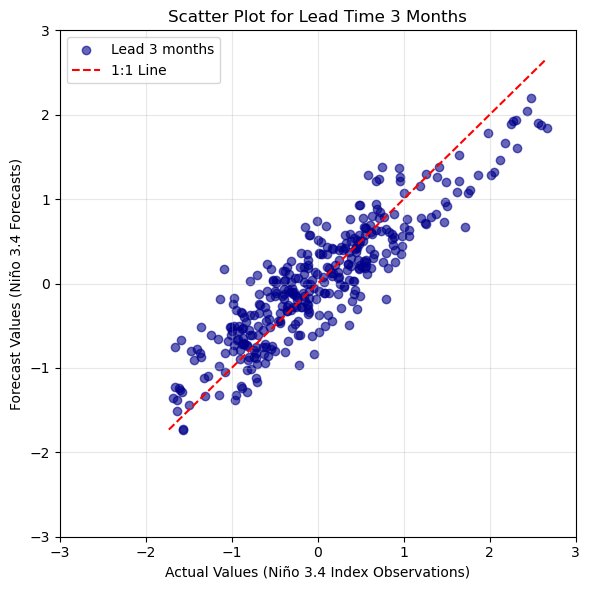

Lead Time 6 Months:
Mean Bias Error (MBE): 0.11
Skewness of Forecasts: -0.03
MBE (Warm Anomalies): -0.40287980252913025
MBE (Cold Anomalies): 0.538354902988625


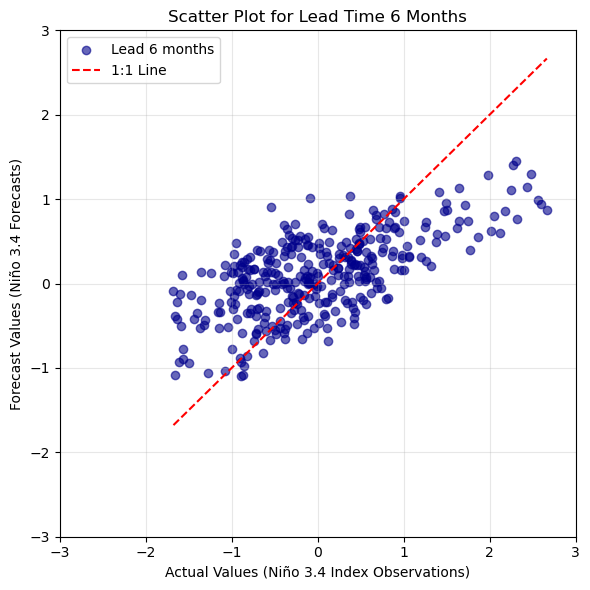

In [ ]:
# Function to create scatter plots for specified lead times
def create_scatter_plots(results, lead_times):
    for lead_time in lead_times:
        forecasts = []
        actuals = []

        # Extract data for the specified lead time
        for lag, data in results.items():
            if lag == lead_time:  # Check if the lag matches the lead time
                forecasts.extend(data["Forecasts"])
                actuals.extend(data["Actuals"])

        # Convert to numpy arrays
        forecasts = np.array(forecasts)
        actuals = np.array(actuals)

        # Handle cases where no data is available
        if len(forecasts) == 0 or len(actuals) == 0:
            print(f"No data available for lead time {lead_time} months.")
            continue

        # Compute skewness and mean bias error
        forecast_skew = skew(forecasts)
        actuals_skew = skew(actuals)
        mbe = np.mean(forecasts - actuals)
        
        # Calculate skewness difference
        print(f"Lead Time {lead_time} Months:")
        print(f"Mean Bias Error (MBE): {mbe:.2f}")
        print(f"Skewness of Forecasts: {forecast_skew:.2f}")
        # Split data into warm and cold anomalies
        warm_indices = actuals > 0
        cold_indices = actuals < 0

        warm_forecasts = forecasts[warm_indices]
        warm_actuals = actuals[warm_indices]

        cold_forecasts = forecasts[cold_indices]
        cold_actuals = actuals[cold_indices]

        # Calculate MBE for warm and cold anomalies
        mbe_warm = np.mean(warm_forecasts - warm_actuals)
        mbe_cold = np.mean(cold_forecasts - cold_actuals)

        print("MBE (Warm Anomalies):", mbe_warm)
        print("MBE (Cold Anomalies):", mbe_cold)

        # Create scatter plot
        plt.figure(figsize=(6, 6))
        plt.scatter(actuals, forecasts, color='darkblue', alpha=0.6, label=f'Lead {lead_time} months')

        # Add 1:1 line (perfect agreement line)
        min_val = min(min(actuals), min(forecasts))
        max_val = max(max(actuals), max(forecasts))
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

        # Formatting
        plt.title(f"Scatter Plot for Lead Time {lead_time} Months")
        plt.xlabel("Actual Values (Ni\u00f1o 3.4 Index Observations)")
        plt.ylabel("Forecast Values (Ni\u00f1o 3.4 Forecasts)")
        plt.ylim(-3, 3)
        plt.xlim(-3, 3)
        plt.grid(alpha=0.3)
        plt.legend()
        plt.tight_layout()

        plt.show()

# Example Usage
lead_times_to_plot = [3, 6]  # Specify the lead times you want
create_scatter_plots(forecast_results_by_variable_full, lead_times_to_plot)


### Event Functions

In [ ]:

def perform_forecast_with_dictionary_events(yt, merged_data, dictionary, forecast_end_date, k, end_idx=None):
    """
    Perform forecasts based on the dictionary, using the specified lag as both forecast horizon and common lag.
    Optionally restrict forecasting to an end index.

    Parameters:
    - yt: Array of observed data (endogenous variable).
    - dictionary: Nested dictionary containing variable information, lags, regions, and data.
    - training_end_idx: Index marking the end of the training data.
    - k: Number of explanatory variables.
    - end_idx: Optional index marking the end of the forecasting period.

    Returns:
    - results: Dictionary with forecasts, actuals, RMSE values, and regions for each variable and lag.
    """
    results = {}
    forecast_end_date = pd.to_datetime(forecast_end_date)
    dates = pd.to_datetime(merged_data['Date'])
    forecast_end_idx = dates[dates <= forecast_end_date].index[-1] + 1
    yt = yt[:forecast_end_idx]

    for lag, data in dictionary.items():
        training_end_date = forecast_end_date - pd.DateOffset(months=lag)
        training_end_idx = dates[dates <= training_end_date].index[-1] + 1
        yt_train = yt[:training_end_idx]
        k = data.shape[1]  # Get the number of columns in the DataFrame
        column_names = [f"Value_{i+1}" for i in range(k)]  # Generate column names dynamically
        
        xt_values_lagged = create_lagged_series_with_extension_multiple(data, column_names, lag=lag)
        xt_train = xt_values_lagged[:training_end_idx] if xt_values_lagged is not None else None
        initial_params_4 = [0.1, 0.1, 0.1, 0.15, 0.2, 4.5, 3.0, 2.9, 2.5, 2.1, 2.6]

        # Fit the model (assuming CustomStateSpaceModel is defined elsewhere)
        model = CustomStateSpaceModel(
            yt_train,
            None,
            k=0,
            params=initial_params_4,
            use_damping=True,
        )
        model_fit = model.fit(
            start_params=initial_params_4,
            disp=False,
            maxiter=10000,
            factr=1e7,
            bounds = bounds_4

        )

        transformed_params = transform_fitted_params(model_fit.params, use_damping=True)
        T, G, H, a0, P0 = define_state_space_components(model_fit.params, k=1)
        # Capture the last training dates and values
        last_training_dates = dates[training_end_idx - 3:training_end_idx]
        last_training_values = yt_train[-3:]
         # Initialize storage for forecasts and dates
        all_forecasts = list(last_training_values)
        all_dates = list(last_training_dates)

        # Start iterative forecasting
        current_idx = training_end_idx


        while current_idx < len(yt):
            print(f"current_idx: {current_idx}")
            yt_subset = yt[:current_idx]
            forecast_dates = dates [current_idx:current_idx + lag]
            forecasts = []

            for step in range(lag):
                print (f" lag: {lag} and step: {step}")
                k = dictionary[step+1].shape[1]  # Get the number of columns in the DataFrame
                column_names = [f"Value_{i+1}" for i in range(k)]  # Generate column names dynamically
                xt_values_lagged = create_lagged_series_with_extension_multiple(dictionary[step+1], column_names, lag=step+1)
                T, G, H, a0, P0 = define_state_space_components(model_fit.params, k=k)
                # Perform Kalman filtering with the specified lag's data
                filtered_states, P, v, F, K = kalman_filter(
                    k=k,
                    y=yt_subset,
                    T=T,
                    G=G,
                    H=H,
                    a0=a0,
                    P0=P0,
                    exog=xt_values_lagged
                )
                
                current_state = filtered_states[:, -1]

                yt_subset = np.append(yt_subset, [np.nan])
                # Define the observation matrix Z_t dynamically based on the current step
                forecast_idx = current_idx + step
                if forecast_idx >= len(yt):  # Stop if we exceed the dataset
                    break
                Z_t = define_Z(
                t=forecast_idx,
                k=k,
                exog=xt_values_lagged
                )
                forecast_value = np.dot(Z_t, current_state)[0]
                forecasts.append(forecast_value)

                    # Append forecasts, actuals, and indices
            all_forecasts.extend(forecasts)
            all_dates.extend(forecast_dates)

            # Move to the next forecast window
            current_idx += lag

        # Compute RMSE for all forecasts
        all_forecasts = np.array(all_forecasts)
        all_dates = np.array(all_dates)

        # Package results into a dictionary
        forecast_results = {
            "dates": all_dates,
            "forecasts": all_forecasts,
        }

        # Store results
        results[lag] = {
            "Forecast": forecast_results["forecasts"],
            "Date": forecast_results["dates"],
        }

    return results

In [ ]:
forecast_results_2000_la_nina= perform_forecast_with_dictionary_events(data_final['Enso'], data_final, final_explanatory, forecast_end_date= '2000-01-01', k=1, end_idx=None)
forecast_results_2009_elnino = perform_forecast_with_dictionary_events(data_final['Enso'], data_final, final_explanatory, forecast_end_date= '2009-12-01',  k=1, end_idx=None)
forecast_results_2002_elnino = perform_forecast_with_dictionary_events(data_final['Enso'], data_final, final_explanatory, forecast_end_date= '2002-11-01',  k=1, end_idx=None)
forecast_results_2011_lanina= perform_forecast_with_dictionary_events(data_final['Enso'], data_final, final_explanatory, forecast_end_date= '2011-12-01',  k=1, end_idx=None)

current_idx: 600
 lag: 1 and step: 0
current_idx: 599
 lag: 2 and step: 0
 lag: 2 and step: 1
current_idx: 598
 lag: 3 and step: 0
 lag: 3 and step: 1
 lag: 3 and step: 2
current_idx: 597
 lag: 4 and step: 0
 lag: 4 and step: 1
 lag: 4 and step: 2
 lag: 4 and step: 3
current_idx: 596
 lag: 5 and step: 0
 lag: 5 and step: 1
 lag: 5 and step: 2
 lag: 5 and step: 3
 lag: 5 and step: 4
current_idx: 595
 lag: 6 and step: 0
 lag: 6 and step: 1
 lag: 6 and step: 2
 lag: 6 and step: 3
 lag: 6 and step: 4
 lag: 6 and step: 5
current_idx: 594
 lag: 7 and step: 0
 lag: 7 and step: 1
 lag: 7 and step: 2
 lag: 7 and step: 3
 lag: 7 and step: 4
 lag: 7 and step: 5
 lag: 7 and step: 6
current_idx: 593
 lag: 8 and step: 0
 lag: 8 and step: 1
 lag: 8 and step: 2
 lag: 8 and step: 3
 lag: 8 and step: 4
 lag: 8 and step: 5
 lag: 8 and step: 6
 lag: 8 and step: 7
current_idx: 592
 lag: 9 and step: 0
 lag: 9 and step: 1
 lag: 9 and step: 2
 lag: 9 and step: 3
 lag: 9 and step: 4
 lag: 9 and step: 5
 lag: 9

## Assumptions

### Assumptions for Main Model

In [ ]:
# Define diagnostic tests function
def diagnostic_tests(standardized_residuals, lags=10, subset_size=None):
    """
    Perform diagnostic tests (normality, heteroscedasticity, and serial correlation) 
    for standardized one-step-ahead prediction errors.

    Parameters:
    - standardized_residuals: Array-like, standardized one-step-ahead prediction errors.
    - lags: Number of lags for the serial correlation (Box-Ljung) test.
    - subset_size: Size of subsets for heteroscedasticity test. Default is half the sample size.

    Returns:
    - diagnostics: Dictionary containing the results of all tests.
    """

    n = len(standardized_residuals)
    subset_size = subset_size or (n // 2)

    # --- Normality Tests ---
    m1 = np.mean(standardized_residuals)  # Mean
    m2 = np.var(standardized_residuals)  # Variance
    m3 = np.mean((standardized_residuals - m1) ** 3)  # Skewness (raw moment)
    m4 = np.mean((standardized_residuals - m1) ** 4)  # Kurtosis (raw moment)
    
    # Normalized skewness and kurtosis
    M3 = m3 / (m2 ** (3 / 2))  # Skewness
    M4 = m4 / (m2 ** 2)  # Kurtosis

    # Combined normality statistic
    MN = n * ((M3 ** 2) / 6 + ((M4 - 3) ** 2) / 24)
    p_value_normality = chi2.sf(MN, df=2)

      # --- Heteroscedasticity Test ---
    e1_squared = standardized_residuals[:subset_size] ** 2
    e2_squared = standardized_residuals[subset_size:] ** 2
    H_h = np.sum(e2_squared) / np.sum(e1_squared)
    df_h = subset_size  # Degrees of freedom for the F-distribution
    p_value_heteroscedasticity = f.sf(H_h, df_h, df_h)  # Survival function for F-distribution

    # --- Serial Correlation Test ---
    ljungbox_test = acorr_ljungbox(standardized_residuals, lags=lags, return_df=True)
    serial_corr_stat = ljungbox_test.iloc[-1]["lb_stat"]  # First lag test statistic
    serial_corr_p_value = ljungbox_test.iloc[-1]["lb_pvalue"]  # First lag p-value

    # --- QQ Plot ---
    #probplot(standardized_residuals, dist="norm", plot=plt)
    #plt.title("QQ Plot of Standardized Residuals")
    #plt.show()

    # Combine diagnostics into a dictionary
    diagnostics = {
        "Normality": {
            "Test Statistic": MN,
            "p_value": p_value_normality
        },
        "Heteroscedasticity": {
            "Test Statistic": H_h,
            "p_value": p_value_heteroscedasticity
        },
        "Serial Correlation": {
            "Test Statistic": serial_corr_stat,
            "p_value": serial_corr_p_value
        }
    }

    return diagnostics

In [ ]:


def test_models_with_diagnostics(yt, dictionary=None, training_end_idx=528, leads=list(range(1, 18)), lags_lb=36):
    """
    Test models, calculate standardized residuals, and perform diagnostic tests, including a base model without predictors.

    Parameters:
    - yt: Array of observed data (endogenous variable).
    - dictionary: Nested dictionary containing variable information, lags, regions, and data (optional for models with predictors).
    - training_end_idx: Index marking the end of the training data.
    - leads: List of lags to test (for models with predictors).
    - lags_lb: Number of lags for the Ljung-Box test.

    Returns:
    - results: Dictionary with standardized residuals and diagnostic tests for each lag, including the base model.
    """
    results = {}
    yt_train = yt[:training_end_idx]

    # --- Base Model (No Predictors) ---
    initial_params_4 = [0.1, 0.1, 0.1, 0.15, 0.2, 4.5, 3.0, 2.9, 2.5, 2.1, 2.6]

    # Fit the base model
    base_model = CustomStateSpaceModel(
        yt_train,
        None,  # No predictors for the base model
        k=0,   # No predictors
        params=initial_params_4,
        use_damping=True,
    )
    base_model_fit = base_model.fit(
        start_params=initial_params_4,
        disp=False,
        maxiter=10000,
        factr=1e7,
        bounds=bounds_4
    )
    T, G, H, a0, P0 = define_state_space_components(base_model_fit.params, k=0)

    # Perform Kalman filtering for the base model
    filtered_states, P, v, F, K = kalman_filter(
        k=0,
        y=yt_train,
        T=T,
        G=G,
        H=H,
        a0=a0,
        P0=P0,
        exog=None,
    )

    # Calculate standardized residuals for the base model
    standardized_residuals_base = v / np.sqrt(F)

    # Perform diagnostic tests for the base model
    diagnostics_base = diagnostic_tests(standardized_residuals_base, lags=lags_lb)

    # Save base model results
    results["base"] = {
        "Standardized_Residuals": standardized_residuals_base,
        "Diagnostics": diagnostics_base
    }

    # --- Models with Predictors ---
    if dictionary is not None:
        for lag in leads:
            data = dictionary.get(lag, None)  # Retrieve data for the current lag
            
            # If data is not None, calculate k and create column names; otherwise, set k to 0
            if data is not None:
                k = data.shape[1]  # Number of explanatory variables
                column_names = [f"Value_{i+1}" for i in range(k)]
                xt_values_lagged = create_lagged_series_with_extension_multiple(data, column_names, lag=lag)
            else:
                k = 0
                column_names = []
                xt_values_lagged = None
            xt_train = xt_values_lagged[:training_end_idx] if xt_values_lagged is not None else None

            # Fit the model with predictors
            model = CustomStateSpaceModel(
                yt_train,
                xt_train,
                k=k,
                params=initial_params_4,
                use_damping=True,
            )
            model_fit = model.fit(
                start_params=initial_params_4,
                disp=False,
                maxiter=10000,
                factr=1e7,
                bounds=bounds_4
            )
            T, G, H, a0, P0 = define_state_space_components(model_fit.params, k=k)

            # Perform Kalman filtering for the model with predictors
            filtered_states, P, v, F, K = kalman_filter(
                k=k,
                y=yt_train,
                T=T,
                G=G,
                H=H,
                a0=a0,
                P0=P0,
                exog=xt_train,
            )

            # Calculate standardized residuals
            standardized_residuals = v / np.sqrt(F)

            # Perform diagnostic tests
            diagnostics = diagnostic_tests(standardized_residuals, lags=lags_lb)

            # Save results for this lag
            results[lag] = {
                "Standardized_Residuals": standardized_residuals,
                "Diagnostics": diagnostics
            }

    return results



In [ ]:
# Example Usage
# Assuming `yt` and `final_explanatory` are already defined
test_results = test_models_with_diagnostics(
    yt=yt,
    dictionary=final_explanatory,
    training_end_idx=528,
    leads=list(range(1, 25)),
    lags_lb=36
)


# Output diagnostics for each lag
for lag, result in test_results.items():
    print(f"--- Lag {lag} ---")
    #print(f"Standardized Residuals:\n{result['Standardized_Residuals']}")
    print("Diagnostics:")
    for test_name, test_results in result['Diagnostics'].items():
        print(f"{test_name}: {test_results}")


--- Lag base ---
Diagnostics:
Normality: {'Test Statistic': 2.1889097088976213, 'p_value': 0.3347220294459209}
Heteroscedasticity: {'Test Statistic': 0.9753975192559299, 'p_value': 0.5801108592326006}
Serial Correlation: {'Test Statistic': 66.3806916547111, 'p_value': 0.0015166540331156657}
--- Lag 1 ---
Diagnostics:
Normality: {'Test Statistic': 2.538553483426202, 'p_value': 0.2810348090456344}
Heteroscedasticity: {'Test Statistic': 0.8843167350408516, 'p_value': 0.8407415273588847}
Serial Correlation: {'Test Statistic': 87.36057921221965, 'p_value': 3.7029399856797095e-06}
--- Lag 2 ---
Diagnostics:
Normality: {'Test Statistic': 3.208622868096705, 'p_value': 0.20102792825190355}
Heteroscedasticity: {'Test Statistic': 0.9096106429493154, 'p_value': 0.778990486281715}
Serial Correlation: {'Test Statistic': 82.30947804166587, 'p_value': 1.7423318826762252e-05}
--- Lag 3 ---
Diagnostics:
Normality: {'Test Statistic': 4.680274080225443, 'p_value': 0.09631443838456656}
Heteroscedasticity: 

### Assumptions for Seasonality

In [ ]:
results_seasonality = {}
yt_train = yt[:528]

# --- Base Model (No Predictors) ---
initial_params_2 = [0.1, 0.1, 0.1, 0.1, 0.15, 0.2, 4.5, 3.0, 2.9, 2.5, 2.1, 2.6]

# Fit the base model
base_model_seasonality = CustomStateSpaceModel(
    yt_train,
    None,  # No predictors for the base model
    k=0,   # No predictors
    params=initial_params_2,
    use_damping=True,
    model_type = 2
)
base_model_fit_seasonality = base_model_seasonality.fit(
    start_params=initial_params_2,
    disp=False,
    maxiter=10000,
    factr=1e7,
)
T, G, H, a0, P0 = define_state_space_components(base_model_fit_seasonality.params, k=0, model_type=2)

# Perform Kalman filtering for the base model
filtered_states_2, P_2, v_2, F_2, K_2 = kalman_filter(
    k=0,
    y=yt_train,
    T=T,
    G=G,
    H=H,
    a0=a0,
    P0=P0,
    exog=None,
)

# Calculate standardized residuals for the base model
standardized_residuals_base_2 = v_2 / np.sqrt(F_2)

# Perform diagnostic tests for the base model
diagnostics_base_2 = diagnostic_tests(standardized_residuals_base_2, lags=36)

# Save base model results
results_seasonality["base"] = {
    "Standardized_Residuals": standardized_residuals_base_2,
    "Diagnostics": diagnostics_base_2
}

In [ ]:
results_seasonality

{'base': {'Standardized_Residuals': array([-2.78072877e-02, -5.47426544e-02, -8.65761370e-02, -2.70895427e-01,
         -1.92957275e-01,  2.52443064e+00, -5.03989960e-01, -1.29305929e+00,
         -6.72012017e-01, -2.99677879e-01, -1.27169484e+00, -6.36958658e-01,
          4.12206017e-01,  1.49326061e+00,  1.88184619e+00,  4.02820027e-01,
          4.47953606e-02,  2.60198704e-01,  8.97122162e-01, -1.02762367e+00,
          1.15565334e+00,  8.64476983e-02, -2.01611438e-01, -1.57530817e+00,
         -5.04794463e-01,  4.03086426e-02, -3.03459179e-01,  1.04163664e+00,
         -3.72814855e-01, -4.95256831e-01, -2.74713519e-01,  1.03705477e+00,
          9.60927226e-01,  1.52612174e-01, -1.39447293e+00,  8.91921887e-01,
          2.09299333e+00,  1.52170417e-01, -2.29505097e-01, -6.69995938e-02,
          3.28569318e-01,  9.03159609e-01, -7.78192872e-01, -1.60001828e-01,
          9.90732976e-01,  1.42008805e-01,  3.75552048e-02,  2.84511133e-01,
          1.07036340e-01, -2.85127983e-01,

### Testing the damping factors

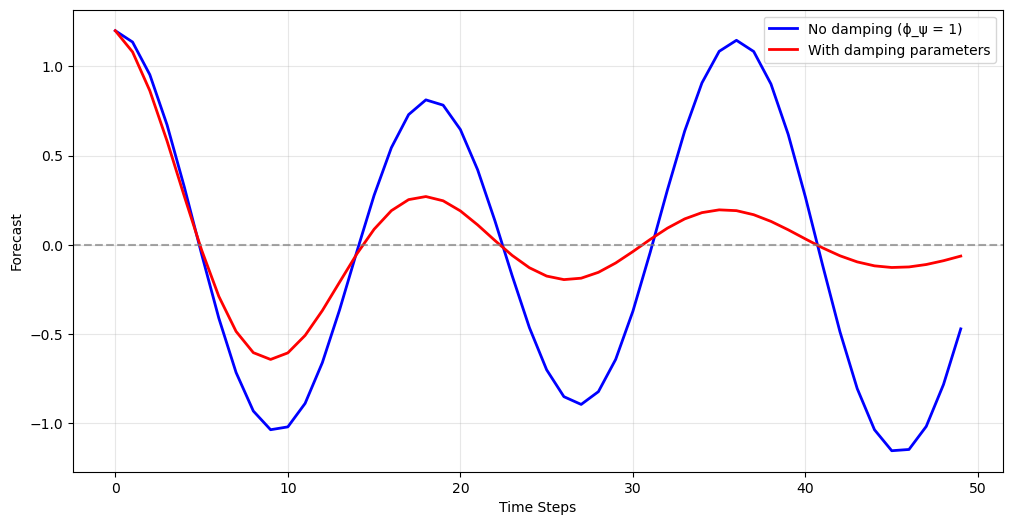

In [ ]:
# Define parameters for the state transition
phi_psi_no_damping = [1, 1, 1]  # No damping
phi_psi_damping = [0.9749, 0.9696, 0.9474]  # With damping
lambda_c = [0.1083, 0.1948, 0.347]  # Angular frequencies in radians per time step

# Define the initial Z matrix and state vector
z_matrix = np.array([1, 0, 1, 0, 1, 0])  # Initial observation matrix
initial_state = [0, 0, 0.2, 0.0, 1, 0.0]  # Initial state: [cos1, sin1, cos2, sin2, cos3, sin3]

# Time steps
steps = 50
time = np.arange(steps)

def generate_forecasts(phi_psi, lambda_c, initial_state, z_matrix, steps):
    # Define the transition matrix
    transition_matrix = np.array([
        [phi_psi[0] * np.cos(lambda_c[0]), -phi_psi[0] * np.sin(lambda_c[0]), 0, 0, 0, 0],
        [phi_psi[0] * np.sin(lambda_c[0]), phi_psi[0] * np.cos(lambda_c[0]), 0, 0, 0, 0],
        [0, 0, phi_psi[1] * np.cos(lambda_c[1]), -phi_psi[1] * np.sin(lambda_c[1]), 0, 0],
        [0, 0, phi_psi[1] * np.sin(lambda_c[1]), phi_psi[1] * np.cos(lambda_c[1]), 0, 0],
        [0, 0, 0, 0, phi_psi[2] * np.cos(lambda_c[2]), -phi_psi[2] * np.sin(lambda_c[2])],
        [0, 0, 0, 0, phi_psi[2] * np.sin(lambda_c[2]), phi_psi[2] * np.cos(lambda_c[2])]
    ])
    
    # Calculate states and forecasts
    states = [initial_state]
    forecasts = [np.dot(z_matrix, initial_state)]
    
    for _ in range(1, steps):
        next_state = np.dot(transition_matrix, states[-1])  # Apply the transition matrix
        states.append(next_state)
        forecasts.append(np.dot(z_matrix, next_state))  # Translate to forecast using Z matrix
    
    return np.array(forecasts)

# Generate forecasts for both cases
forecasts_no_damping = generate_forecasts(phi_psi_no_damping, lambda_c, initial_state, z_matrix, steps)
forecasts_damping = generate_forecasts(phi_psi_damping, lambda_c, initial_state, z_matrix, steps)

# Plotting the forecast results
plt.figure(figsize=(12, 6))

# Without damping
plt.plot(time, forecasts_no_damping, label="No damping (ϕ_ψ = 1)", color="blue", linewidth=2)

# With damping
plt.plot(time, forecasts_damping, label="With damping parameters", color="red", linewidth=2)

plt.axhline(0, color='grey', linestyle='--', alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Forecast")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Visualisations

### Different Cycles Plotted

In [15]:
# Define the target variable and the lag structure
yt = data_final['Enso']
yt_new = yt[:525]

bounds_4 = [
    (None, None),  # σ_ε
    (None, None),  # σ_η
    (None, None),  # σ_κ1
    (None, None),  # σ_κ2
    (None, None),  # σ_κ3
    (None, None), # φ_ψ1
    (None, None), # φ_ψ2
    (None, None),  # φ_ψ3
    (3.85, 4.23), # λ_c1 (Frequency for cycle 1)
    (3.14, 3.71), # λ_c2 (Frequency for cycle 2)
    (2.38, 2.89), # λ_c3 (Frequency for cycle 3)
]
# Define initial parameters for model type 4
initial_params_4 = [0.1, 0.1, 0.1, 0.1, 0.1, 4.5, 3.0, 2.9, 2.5, 2.1, 2.6]

# Define a function to create, fit, and extract information from the model
def fit_and_evaluate_model_4(yt, xt_values, initial_params, k, bounds):
    print("\n=== Fitting Model Type 4 ===")
    
    # Initialize the model
    model = CustomStateSpaceModel(
        yt,
        xt_values,
        k=k,
        params=initial_params,
        use_damping=True,
    )
    
    # Fit the model
    model_fit = model.fit(start_params=initial_params, disp=False, maxiter=1000000, bounds = bounds)
    filtered_states = model_fit.filtered_state
    
    # Get and transform the fitted parameters
    transformed_params = transform_fitted_params(model_fit.params, use_damping=True)
    
    # Print the transformed parameters with labels
    print("Transformed Parameters:")
    for name, value in transformed_params.items():
        print(f"{name}: {value:.4f}")  
         
    return model_fit, transformed_params, model, filtered_states, model_fit.params 

# Fit and evaluate the model
model_fit_4, transformed_params_4, model, filtered_sates, untransformed_params = fit_and_evaluate_model_4(
    yt, None, initial_params_4, k=0, bounds= bounds_4
)


=== Fitting Model Type 4 ===
Transformed Parameters:
σ_ε: 0.0009
σ_η: 0.0031
σ_κ1: 0.1399
σ_κ2: 0.1041
σ_κ3: 0.1101
φ_ψ1: 0.9747
φ_ψ2: 0.9697
φ_ψ3: 0.9474
λ_c1: 0.1087
λ_c2: 0.1978
λ_c3: 0.3465


Shape of explanatory_part: (888,)


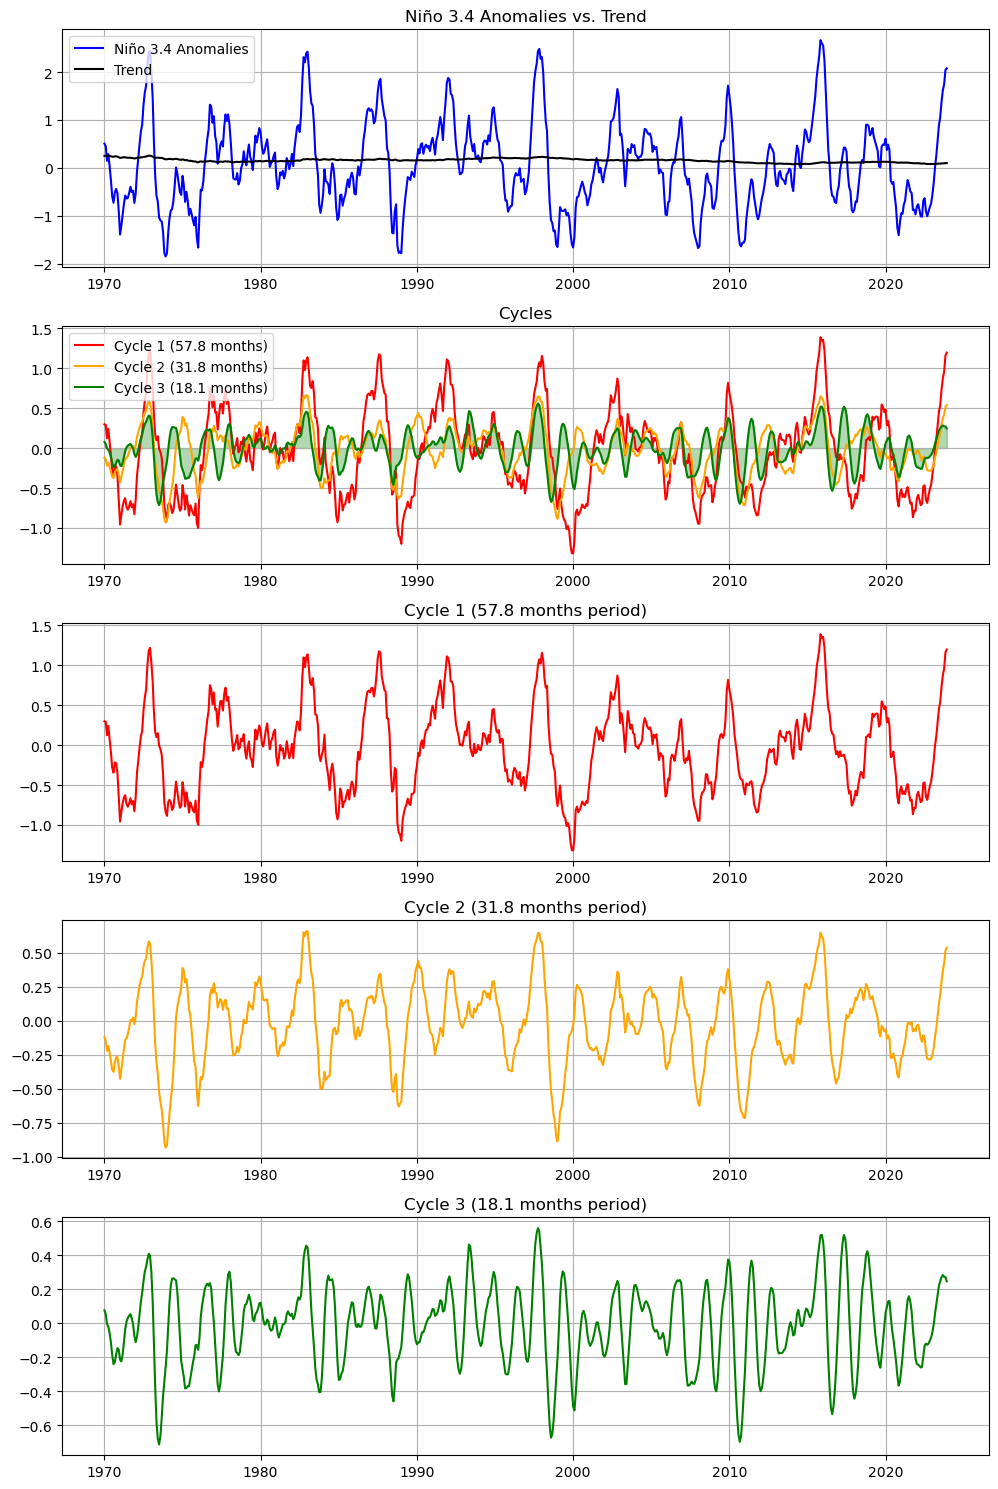

In [16]:
# Extract estimated cycle frequencies from the transformed parameters
λ_c1 = transformed_params_4['λ_c1']  # First cycle frequency
λ_c2 = transformed_params_4['λ_c2']  # Second cycle frequency
λ_c3 = transformed_params_4['λ_c3']  # Third cycle frequency

# Calculate the periods of the cycles
period_1 = round(2 * np.pi / λ_c1, 1)
period_2 = round(2 * np.pi / λ_c2, 1)
period_3 = round(2 * np.pi / λ_c3, 1)

# Decompose the filtered states into components

design_matrix = model_fit_4.model['design']  # Shape: (1, 8, 888)
# Ensure explanatory_numbers is 1D and matches the relevant dimension
explanatory_numbers = design_matrix[0, -1, :]  # Shape: (888,)

# Extract the last k rows of filtered states
filtered_states_part = filtered_sates[-k:, :]  # Shape: (k, 888)

# Perform element-wise multiplication for each time step and sum along k (rows)
explanatory_part = np.sum(filtered_states_part * explanatory_numbers, axis=0)  # Shape: (888,)

# Print the shape to verify
print("Shape of explanatory_part:", explanatory_part.shape)

trend_part = filtered_sates[0, :]
combined_trend_explanatory = trend_part + explanatory_part

# Cycle components extraction
cycle_1_component = filtered_sates[1, :].flatten()
cycle_2_component = filtered_sates[3, :].flatten()
cycle_3_component = filtered_sates[5, :].flatten()

# Adjust the date range to match the filtered states
data_dates = pd.to_datetime(data_final['Date'])
start_date = '1970-01-01'
start_index = data_dates[data_dates >= start_date].index[0]
adjusted_dates = data_dates.iloc[start_index:].reset_index(drop=True)

# Trim components and ENSO series to match adjusted dates
enso_series = data_final['Enso'].iloc[start_index:].reset_index(drop=True)
combined_trend_explanatory = combined_trend_explanatory[start_index:]
cycle_1_component = cycle_1_component[start_index:]
cycle_2_component = cycle_2_component[start_index:]
cycle_3_component = cycle_3_component[start_index:]

# Plotting the results
plt.figure(figsize=(10, 15))

# (a) Original ENSO series and combined trend + explanatory variables
plt.subplot(5, 1, 1)
plt.plot(adjusted_dates, enso_series, label='Niño 3.4 Anomalies', color='blue')
plt.plot(adjusted_dates, combined_trend_explanatory, label='Trend', color='black')
plt.title('Niño 3.4 Anomalies vs. Trend')
plt.legend()
plt.grid()

# (b) Overlapping plot for cycle components
plt.subplot(5, 1, 2)
plt.plot(adjusted_dates, cycle_1_component, label=f'Cycle 1 ({period_1} months)', color='red')
plt.plot(adjusted_dates, cycle_2_component, label=f'Cycle 2 ({period_2} months)', color='orange')
plt.plot(adjusted_dates, cycle_3_component, label=f'Cycle 3 ({period_3} months)', color='green')
plt.fill_between(adjusted_dates, cycle_3_component, 0, color='green', alpha=0.3)  # Fill under Cycle 3
plt.title('Cycles')
plt.legend()
plt.grid()

# (c) Cycle 1 component alone
plt.subplot(5, 1, 3)
plt.plot(adjusted_dates, cycle_1_component, color='red')
plt.title(f'Cycle 1 ({period_1} months period)')
plt.grid()

# (d) Cycle 2 component alone
plt.subplot(5, 1, 4)
plt.plot(adjusted_dates, cycle_2_component, color='orange')
plt.title(f'Cycle 2 ({period_2} months period)')
plt.grid()

# (e) Cycle 3 component alone
plt.subplot(5, 1, 5)
plt.plot(adjusted_dates, cycle_3_component, color='green')
plt.title(f'Cycle 3 ({period_3} months period)')
plt.grid()

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Figures/Components_Plot_with_Overlapping_Cycles.pdf')  # Save the plot
plt.show()

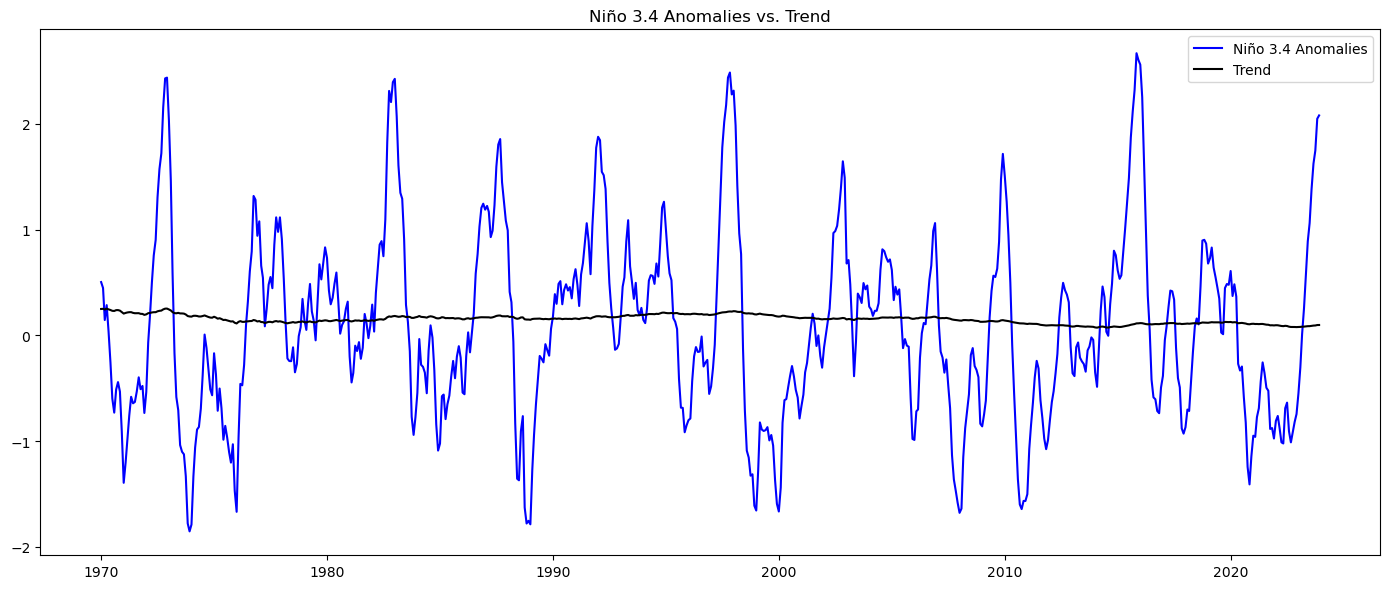

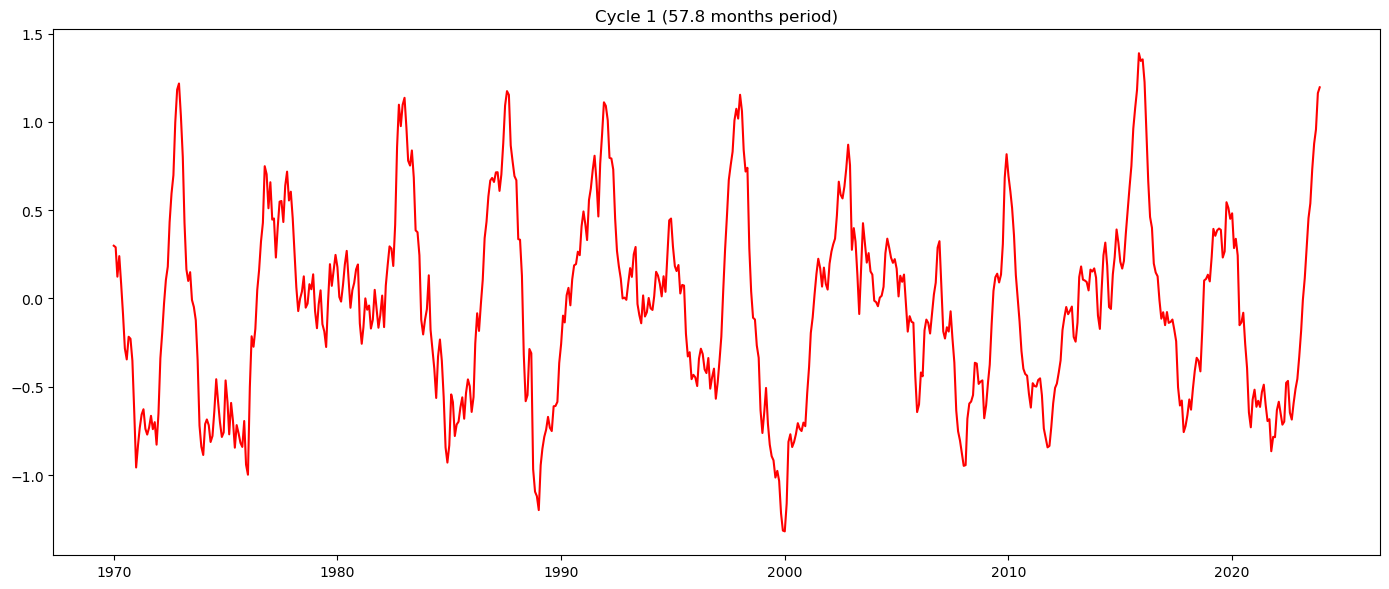

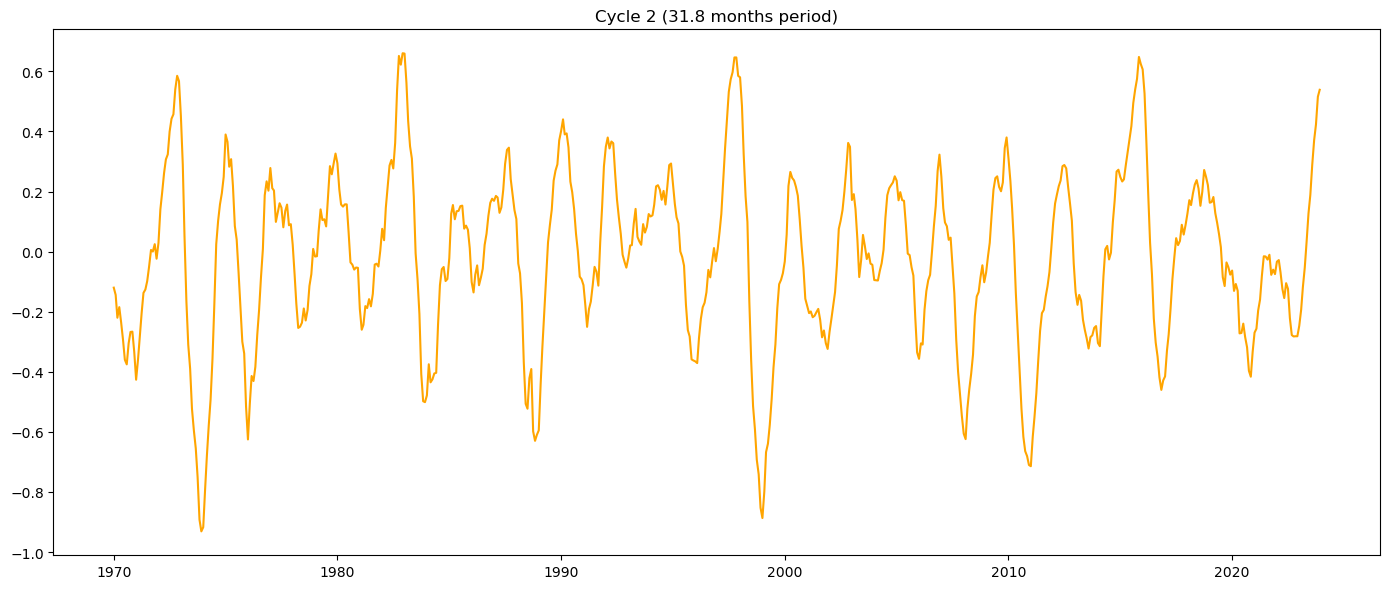

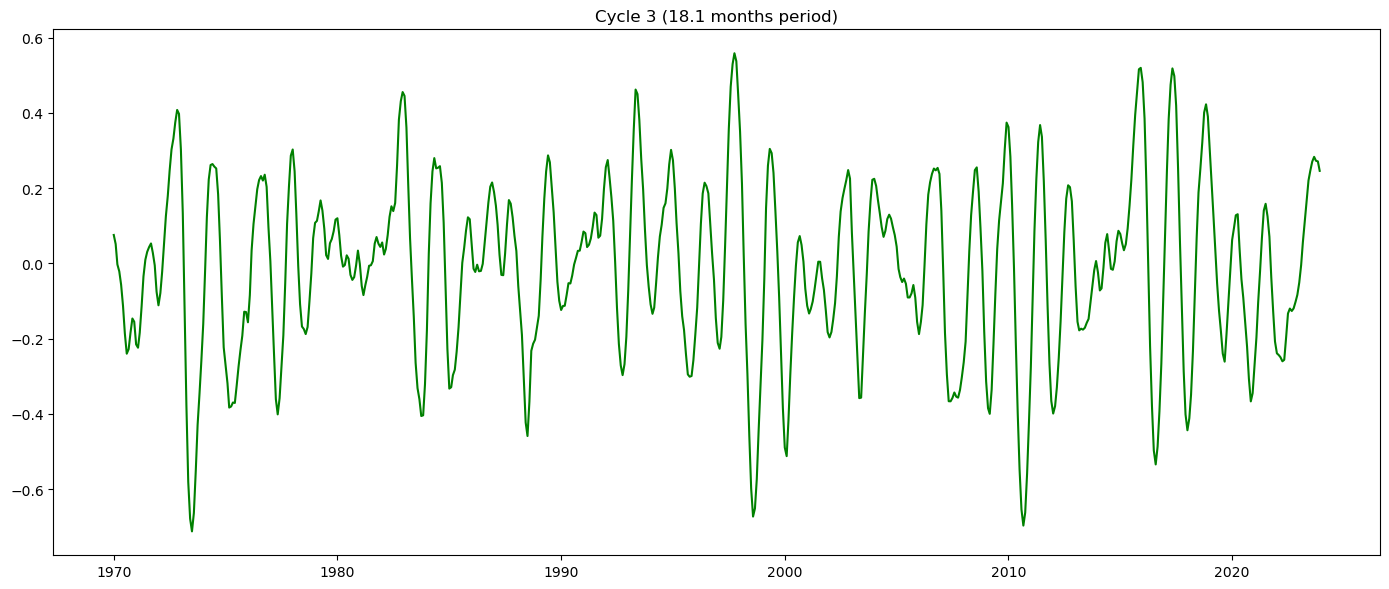

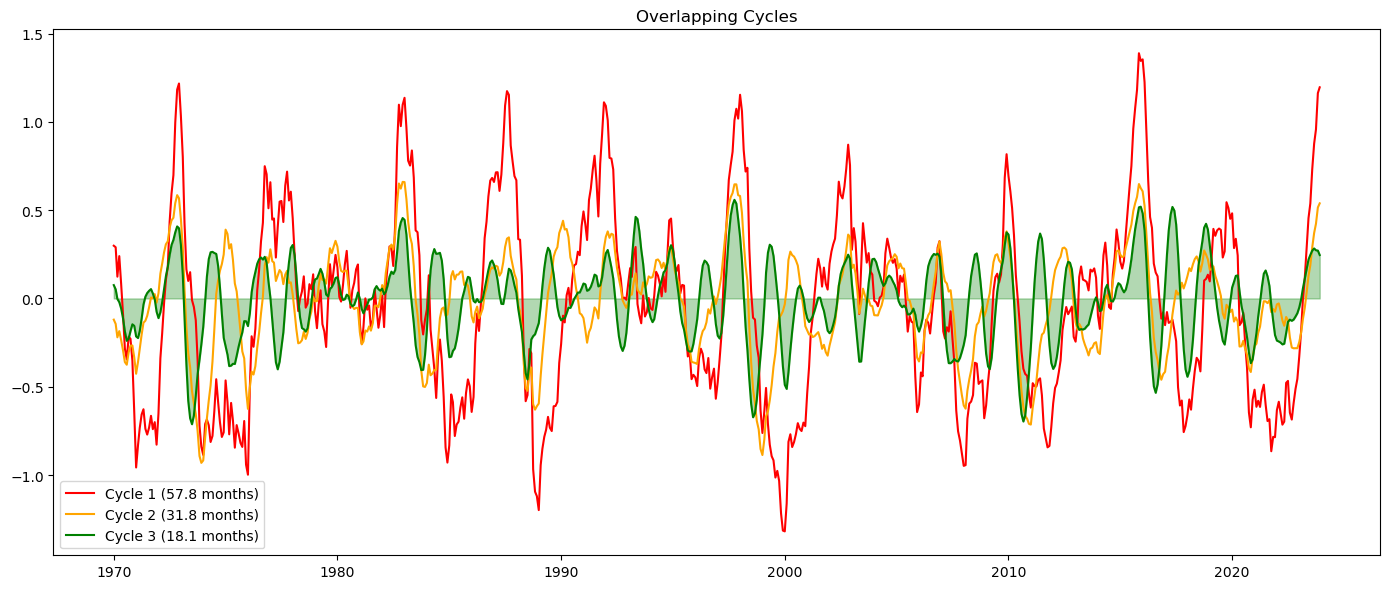

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming `enso_series`, `combined_trend_explanatory`, `cycle_1_component`, `cycle_2_component`,
# `cycle_3_component`, `adjusted_dates`, `period_1`, `period_2`, and `period_3` are already defined.

# Plot 1: Niño 3.4 Anomalies vs. Combined Trend + Explanatory Variables
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, enso_series, label='Niño 3.4 Anomalies', color='blue')
plt.plot(adjusted_dates, combined_trend_explanatory, label='Trend', color='black')
plt.title('Niño 3.4 Anomalies vs. Trend')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('Figures/Nino34_vs_Trend.pdf')
plt.show()

# Plot 2: Cycle 1 Component
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, cycle_1_component, color='red')
plt.title(f'Cycle 1 ({period_1} months period)')
plt.grid(False)
plt.tight_layout()
plt.savefig('Figures/Cycle_1_Component.pdf')
plt.show()

# Plot 3: Cycle 2 Component
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, cycle_2_component, color='orange')
plt.title(f'Cycle 2 ({period_2} months period)')
plt.grid(False)
plt.tight_layout()
plt.savefig('Figures/Cycle_2_Component.pdf')
plt.show()

# Plot 4: Cycle 3 Component
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, cycle_3_component, color='green')
plt.title(f'Cycle 3 ({period_3} months period)')
plt.grid(False)
plt.tight_layout()
plt.savefig('Figures/Cycle_3_Component.pdf')
plt.show()

# Plot 5: Overlapping Cycles
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, cycle_1_component, label=f'Cycle 1 ({period_1} months)', color='red')
plt.plot(adjusted_dates, cycle_2_component, label=f'Cycle 2 ({period_2} months)', color='orange')
plt.plot(adjusted_dates, cycle_3_component, label=f'Cycle 3 ({period_3} months)', color='green')
plt.fill_between(adjusted_dates, cycle_3_component, 0, color='green', alpha=0.3)  # Fill under Cycle 3
plt.title('Overlapping Cycles')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('Figures/Overlapping_Cycles.pdf')
plt.show()


### General Forecast Plots 

In [20]:
def plot_forecast_results(forecast_results, end_date="2023-12-01", y_limits=(-2.5, 3.5)):
    """
    Plots forecasts vs actuals for all lags and calculates PC and RMSE.

    Parameters:
    - forecast_results: Dictionary containing forecasts, actuals, indices, and RMSE for each lag.
    - end_date: The last date in the dataset (as a string in 'YYYY-MM-DD' format).

    Returns:
    - performance_metrics: Dictionary with PC and RMSE for each lag.
    """
    performance_metrics = {}

    # Calculate the dates
    end_date = pd.to_datetime(end_date)
    num_points = max(len(data["Forecasts"]) for data in forecast_results.values())
    dates = pd.date_range(end=end_date, periods=num_points, freq="MS")

    # Loop through each lag in the results
    for lag, data in forecast_results.items():
        forecasts = data["Forecasts"]
        actuals = data["Actuals"]
        lag = lag +1

        # Calculate Pearson Correlation (PC) and RMSE
        pc = np.corrcoef(forecasts, actuals)[0, 1]
        rmse = np.sqrt(np.mean((np.array(forecasts) - np.array(actuals)) ** 2))

        # Store metrics
        performance_metrics[lag] = {"PC": pc, "RMSE": rmse}

        # Plot forecasts vs actuals
        plt.figure(figsize=(8, 5))
        plt.plot(dates[:len(actuals)], actuals, label="Niño 3.4 Index", color="blue")
        plt.plot(dates[:len(forecasts)], forecasts, label="Forecasts", color="orange", linewidth=2)
        plt.title(f"Forecast vs Actuals for Lag {lag}")
        plt.xlabel("Date")
        plt.ylabel("°C")
        plt.ylim(y_limits)  # Set y-axis limits

        plt.legend()
        plt.grid(alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Save the plot with the appropriate filename
        filename = f"Figures/forecast_lead_{lag}.png"
        plt.savefig(filename)
        plt.close()  # Close the plot to avoid displaying it during the loop

    return performance_metrics


# Example usage
performance_metrics = plot_forecast_results(forecast_results_by_variable_full, end_date="2023-12-01")


NameError: name 'forecast_results_by_variable_full' is not defined

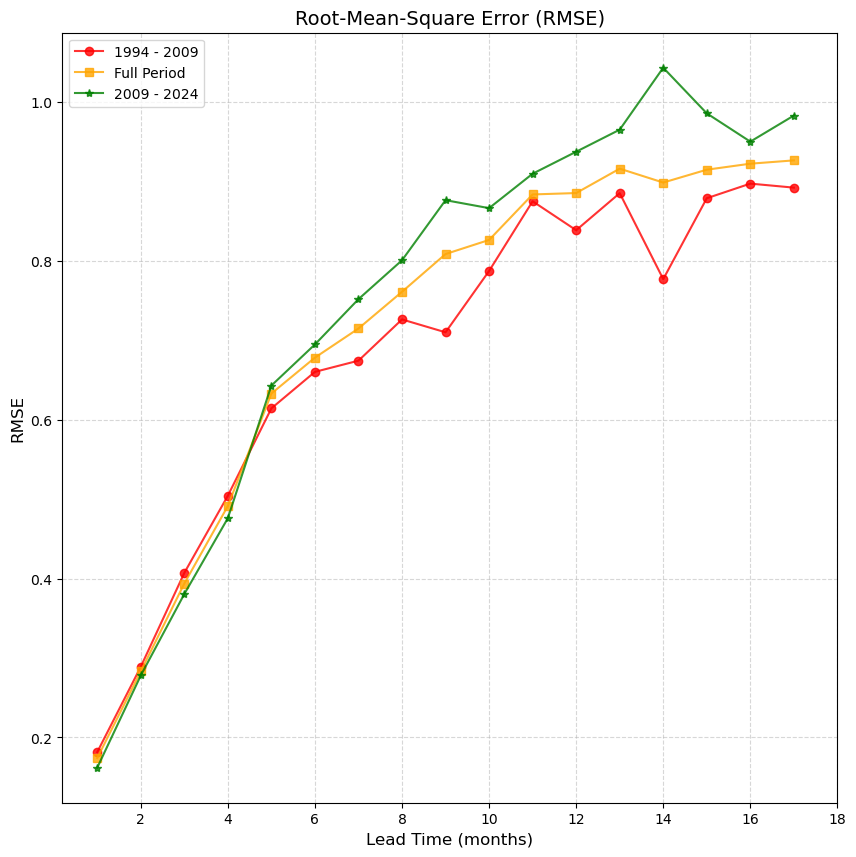

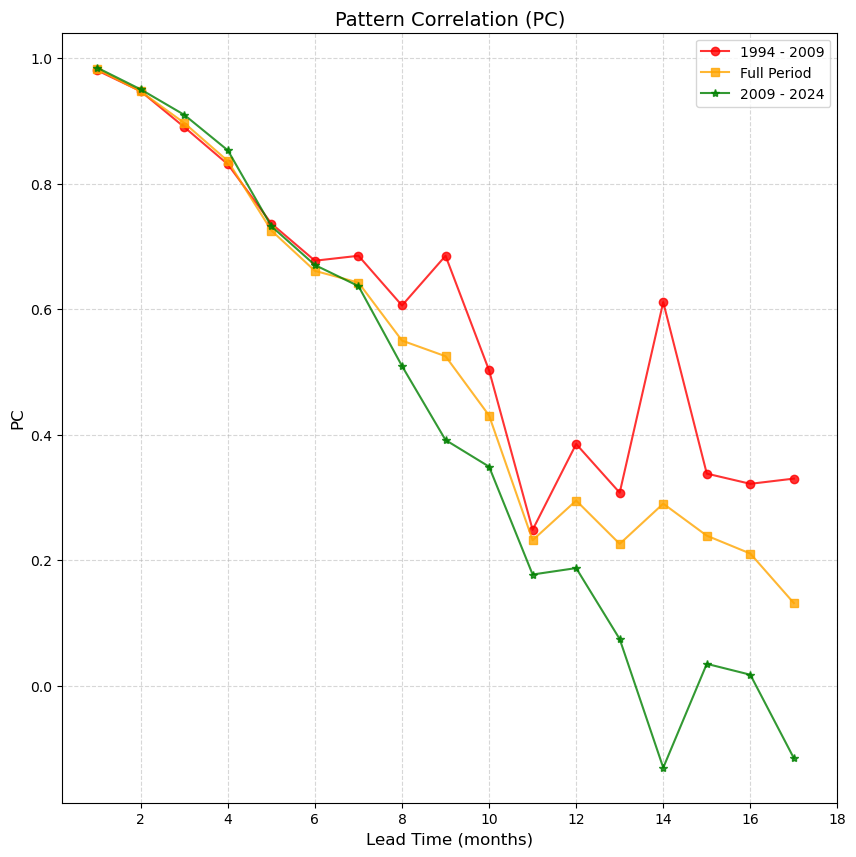

('Figures/RMSE_vs_Lead_Time.png', 'Figures/PC_vs_Lead_Time.png')

In [ ]:
subsets ={"1994 - 2009": forecast_results_by_variable_until_2008,
    "Full Period": forecast_results_by_variable_full,
    '2009 - 2024': forecast_results_by_variable_until_2023
}

# Initialize separate plots for RMSE and PC
fig_rmse, ax_rmse = plt.subplots(figsize=(10, 10))
fig_pc, ax_pc = plt.subplots(figsize=(10, 10))

leads_full_range = np.arange(1, 18)  # Leads from 1 to 24 months

# Colors and markers for the lines
colors = ['red', 'orange', 'green']  # Softer colors
markers = ['o', 's', '*']

# Plot RMSE and PC for each subset
for i, (label, forecast_results) in enumerate(subsets.items()):
    rmse_values = []
    pc_values = []
    
    # Extract RMSE and PC for each lead time
    for lead in range(1, 18):  # Leads from 1 to 24
        rmse_avg = forecast_results[lead]['RMSE']
        pc_avg = forecast_results[lead]['PC']
        rmse_values.append(rmse_avg)
        pc_values.append(pc_avg)
    
    # Plot RMSE
    ax_rmse.plot(leads_full_range, rmse_values, marker=markers[i], linestyle='-', color=colors[i], label=label, alpha=0.8)
    
    # Plot PC
    ax_pc.plot(leads_full_range, pc_values, marker=markers[i], linestyle='-', color=colors[i], label=label, alpha=0.8)

# Add titles, labels, and legends for RMSE plot
ax_rmse.set_title('Root-Mean-Square Error (RMSE)', fontsize=14)
ax_rmse.set_xlabel('Lead Time (months)', fontsize=12)
ax_rmse.set_ylabel('RMSE', fontsize=12)
ax_rmse.set_xticks(np.arange(2, 19, 2))  # Set x-ticks to even numbers only

ax_rmse.grid(True, linestyle='--', alpha=0.5)
ax_rmse.legend(fontsize=10)  # Add legend for RMSE

# Add titles, labels, and legends for PC plot
ax_pc.set_title('Pattern Correlation (PC)', fontsize=14)
ax_pc.set_xlabel('Lead Time (months)', fontsize=12)
ax_pc.set_ylabel('PC', fontsize=12)
ax_pc.set_xticks(np.arange(2, 19, 2))  # Set x-ticks to even numbers only

ax_pc.grid(True, linestyle='--', alpha=0.5)
ax_pc.legend(fontsize=10)  # Add legend for PC

# Save each plot separately
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

rmse_output_path = os.path.join(output_dir, "RMSE_vs_Lead_Time.png")
pc_output_path = os.path.join(output_dir, "PC_vs_Lead_Time.png")

fig_rmse.savefig(rmse_output_path, dpi=300)
fig_pc.savefig(pc_output_path, dpi=300)

plt.show()

rmse_output_path, pc_output_path



### Seasonal Dependence Plots

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/2095584432.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(short_months, fontsize=10)  # Rename x-tick labels
/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/2095584432.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(short_months, fontsize=10)  # Rename x-tick labels


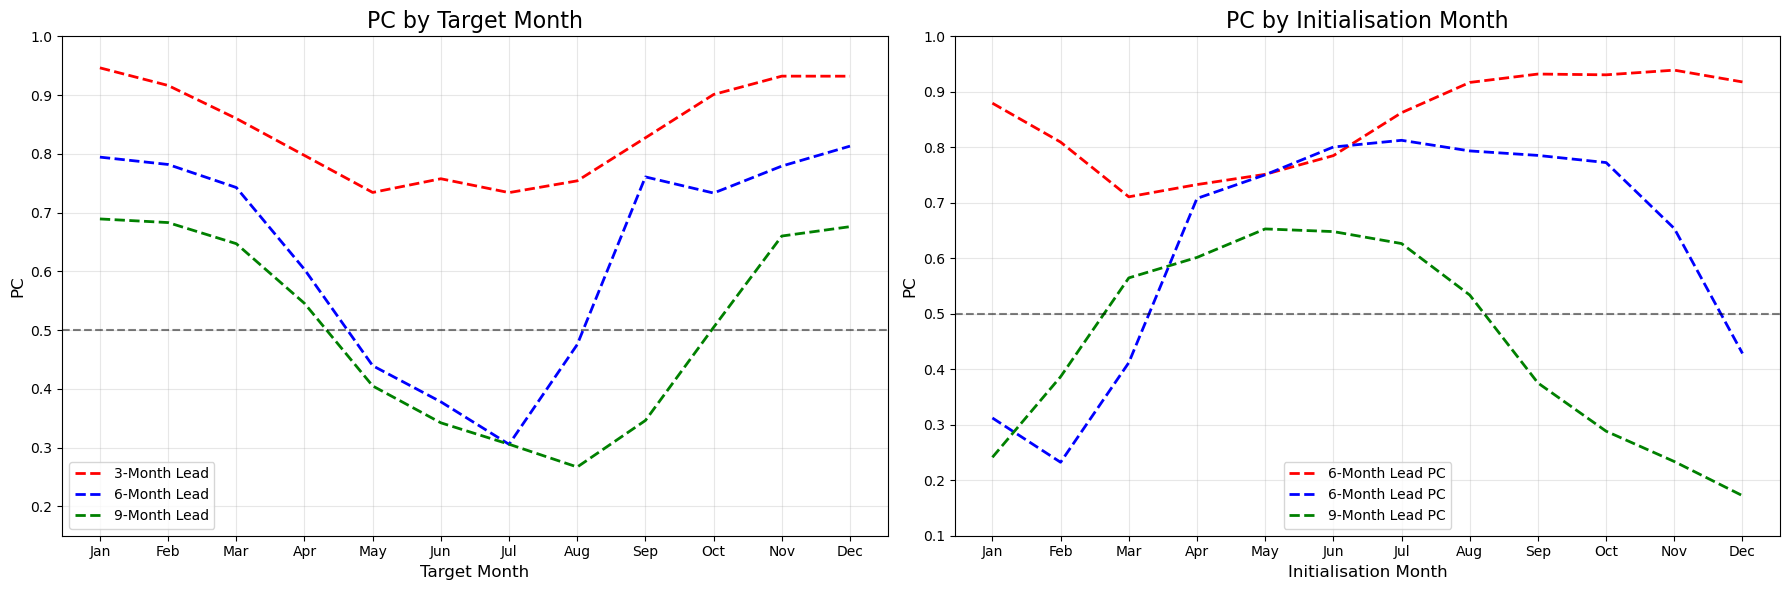

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics_by_month(target_3, target_6, target_9, intilisation_3, initiliastion_6, initialisation_9, save_path="Figures/Comparison_Initialisation_Months.png"):
    """
    Plot RMSE and PC for two lead times (6 and 9 months) across different initialisation months.

    Parameters:
    - metrics_6: Dictionary of RMSE and PC for 6-month lead time by month.
    - metrics_9: Dictionary of RMSE and PC for 9-month lead time by month.
    - save_path: Path to save the resulting plot.

    Returns:
    - None
    """
    months = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    short_months = [
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    ]

    # Extract RMSE and PC values for both lead times
    pc_3_target = [target_3[month]["PC"] if target_3[month]["PC"] is not None else None for month in months]
    pc_6_target = [target_6[month]["PC"] if target_6[month]["PC"] is not None else None for month in months]
    pc_9_target = [target_9[month]["PC"] if target_9[month]["PC"] is not None else None for month in months]
    pc_3_init = [intilisation_3[month]["PC"] if intilisation_3[month]["PC"] is not None else None for month in months]
    pc_6_init = [initiliastion_6[month]["PC"] if initiliastion_6[month]["PC"] is not None else None for month in months]
    pc_9_init = [initialisation_9[month]["PC"] if initialisation_9[month]["PC"] is not None else None for month in months]

    # Create the plot
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))  # Two side-by-side plots

    # RMSE Plot
    ax[0].plot(months, pc_3_target, linestyle='--', color='red', linewidth=2, label="3-Month Lead")
    ax[0].plot(months, pc_6_target, linestyle='--', color='blue', linewidth=2, label="6-Month Lead")
    ax[0].plot(months, pc_9_target, linestyle='--', color='green', linewidth=2, label="9-Month Lead")

    ax[0].set_title("PC by Target Month", fontsize=16)
    ax[0].set_xlabel("Target Month", fontsize=12)
    ax[0].set_ylabel("PC", fontsize=12)
    ax[0].legend()
    ax[0].set_xticklabels(short_months, fontsize=10)  # Rename x-tick labels

    ax[0].grid(alpha=0.3)
    ax[0].axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label="PC = 0.5")

    ax[0].set_ylim(0.15, 1.0)

    # PC Plot
    ax[1].plot(months, pc_3_init, linestyle='--', color='red', linewidth=2, label="6-Month Lead PC")
    ax[1].plot(months, pc_6_init, linestyle='--', color='blue', linewidth=2, label="6-Month Lead PC")
    ax[1].plot(months, pc_9_init, linestyle='--', color='green', linewidth=2, label="9-Month Lead PC")
    ax[1].set_title("PC by Initialisation Month", fontsize=16)
    ax[1].set_xlabel("Initialisation Month", fontsize=12)
    ax[1].set_ylabel("PC", fontsize=12)
    ax[1].legend()
    ax[1].grid(alpha=0.3)
    ax[1].set_xticklabels(short_months, fontsize=10)  # Rename x-tick labels

    ax[1].set_ylim(0.1, 1.0)
    ax[1].axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label="PC = 0.5")

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example Usage (replace metrics_6 and metrics_9 with actual outputs from the calculation functions)
plot_metrics_by_month(calculate_metrics_by_target_month_3, calculate_metrics_by_target_month_6, calculate_metrics_by_target_month_9, initialisation_by_month_3, initialisation_by_month_6, initialisation_by_month_9)


### Event Plots

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_forecasts_by_lags(forecast_data_dict, observed_data, lags, plot_start_date, plot_end_date, custom_label="", smoothing_sigma=None, colormap='viridis', ls1=1, ls2=2, name=""):
    """
    Plots observed ENSO values alongside forecasts for specified lags, using a colormap to color the forecasts.

    Parameters:
    - forecast_data_dict: Dictionary containing forecast arrays and corresponding dates for each lag.
      Each key is a lag, and the value is a dictionary with 'Forecast' and 'Date'.
    - observed_data: DataFrame containing observed values with 'Date' and 'Enso' columns.
    - lags: List of lags to include in the plot.
    - plot_start_date: Start date for the plot (string in 'YYYY-MM-DD' format).
    - plot_end_date: End date for the plot (string in 'YYYY-MM-DD' format).
    - custom_label: Additional label to add to the filename (string, optional).
    - smoothing_sigma: Standard deviation for Gaussian smoothing. If None, no smoothing is applied.
    - colormap: The name of the Matplotlib colormap to use for coloring different lags.
    
    Returns:
    - A plot showing observed ENSO values and forecasts for the specified lags.
    """
    # Ensure Date columns in forecast data and observed data are in datetime format
    observed_data['Date'] = pd.to_datetime(observed_data['Date'])

    # Filter observed data for the specified date range
    observed_data_filtered = observed_data[(observed_data['Date'] >= pd.to_datetime(plot_start_date)) & (observed_data['Date'] <= pd.to_datetime(plot_end_date))]

    # Prepare the colormap
    cmap = cm.get_cmap(colormap)
    colors = cmap(np.linspace(ls1, ls2, len(lags)))  # Use linspace to evenly pick colors from the colormap

    # Plotting
    plt.figure(figsize=(14, 8))
    plt.plot(observed_data_filtered['Date'], observed_data_filtered['Enso'], label='Observed ENSO', color='black', linewidth=4)

    # Plot forecasts for each specified lag
    for idx, lag in enumerate(sorted(lags)):
        if lag in forecast_data_dict:
            forecast_array = forecast_data_dict[lag]['Forecast']
            date_array = forecast_data_dict[lag]['Date']

            # Create a DataFrame from forecast and date arrays for filtering
            forecast_df = pd.DataFrame({'Date': date_array, 'Forecast': forecast_array})
            forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

            # Filter forecast data for the specified date range
            forecast_df_filtered = forecast_df[(forecast_df['Date'] >= pd.to_datetime(plot_start_date)) & (forecast_df['Date'] <= pd.to_datetime(plot_end_date))]

            # Apply Gaussian smoothing if specified
            if smoothing_sigma:
                forecast_df_filtered['Forecast'] = gaussian_filter1d(forecast_df_filtered['Forecast'], sigma=smoothing_sigma)

            # Plot the forecast
            label = f'Lead {lag} months'
            plt.plot(
                forecast_df_filtered['Date'],
                forecast_df_filtered['Forecast'],
                label=label,
                linestyle='-',
                color=colors[idx],
                linewidth=4
            )

            # Add a vertical dotted line at the start of each forecast period
            if not forecast_df_filtered.empty:
                start_date = forecast_df_filtered['Date'].iloc[0]
                end_date = forecast_df_filtered['Date'].iloc[-1]
                plt.axvline(start_date, color=colors[idx], linestyle='--', linewidth=1.5)
    plt.axvline(end_date, color='black', linestyle='--', linewidth=1.5, label='Forecast Target Date')


    # Labeling and formatting
    plt.xlabel('Date')
    plt.ylabel('ENSO Index')
    plt.ylim(-2, 3)
    plt.title(custom_label)
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"Figures/{name}_{lags}.png")
    plt.show()


/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


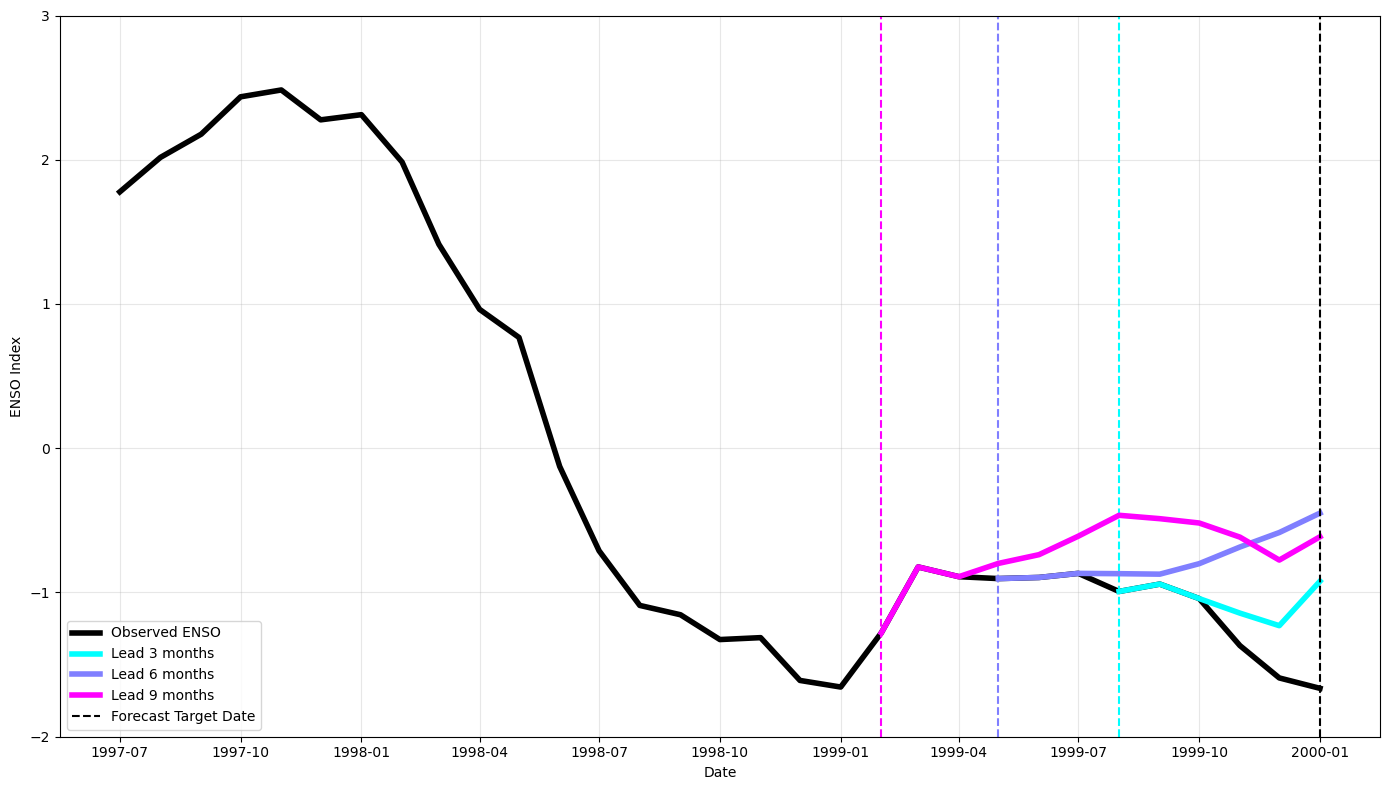

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


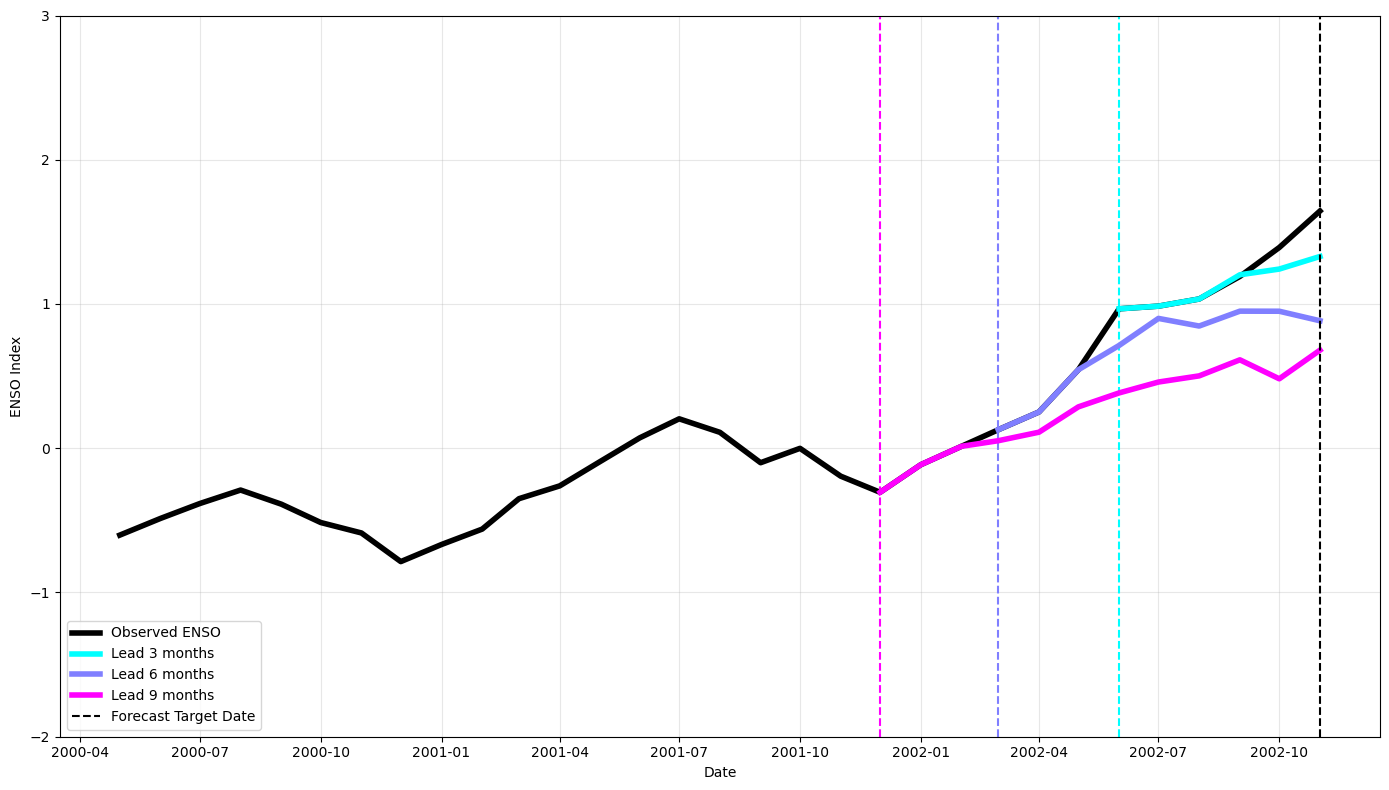

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


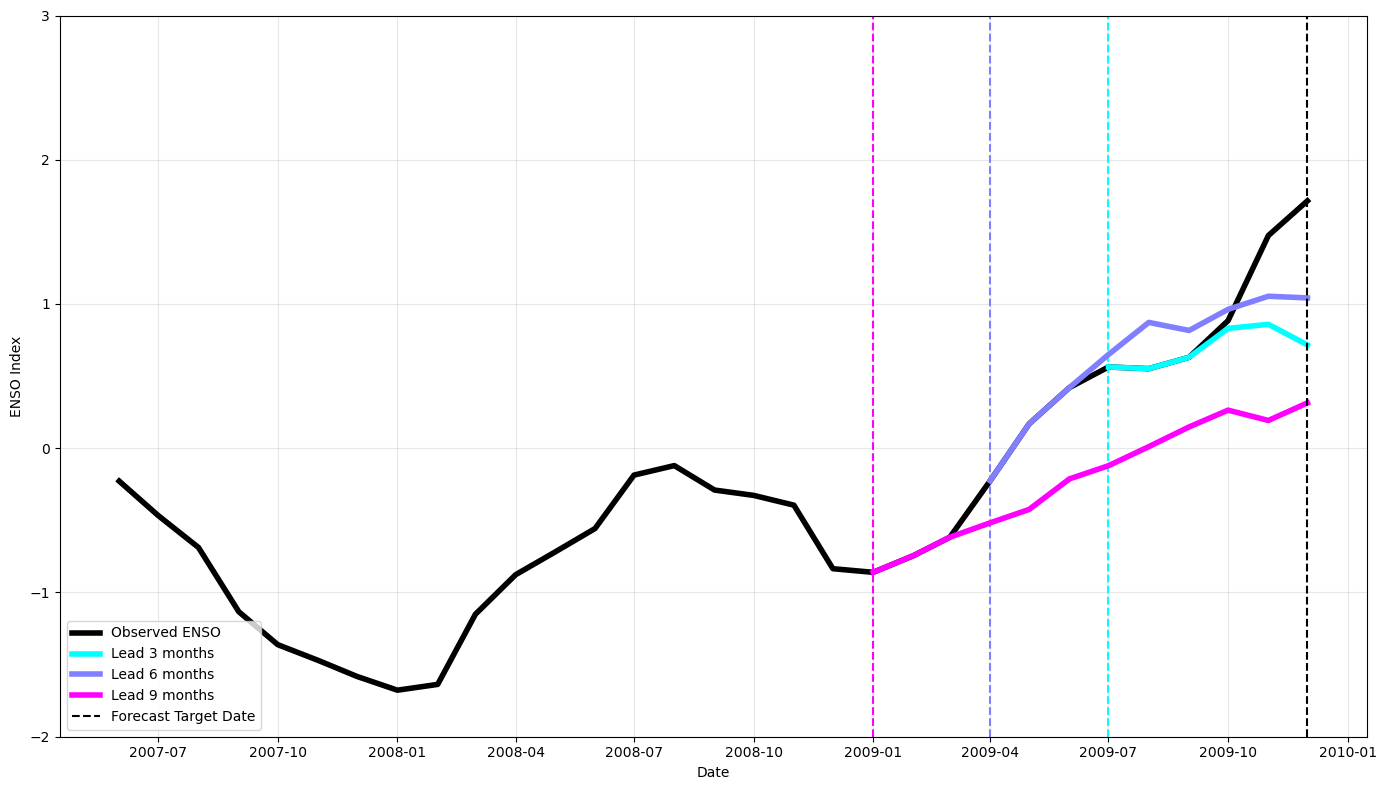

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


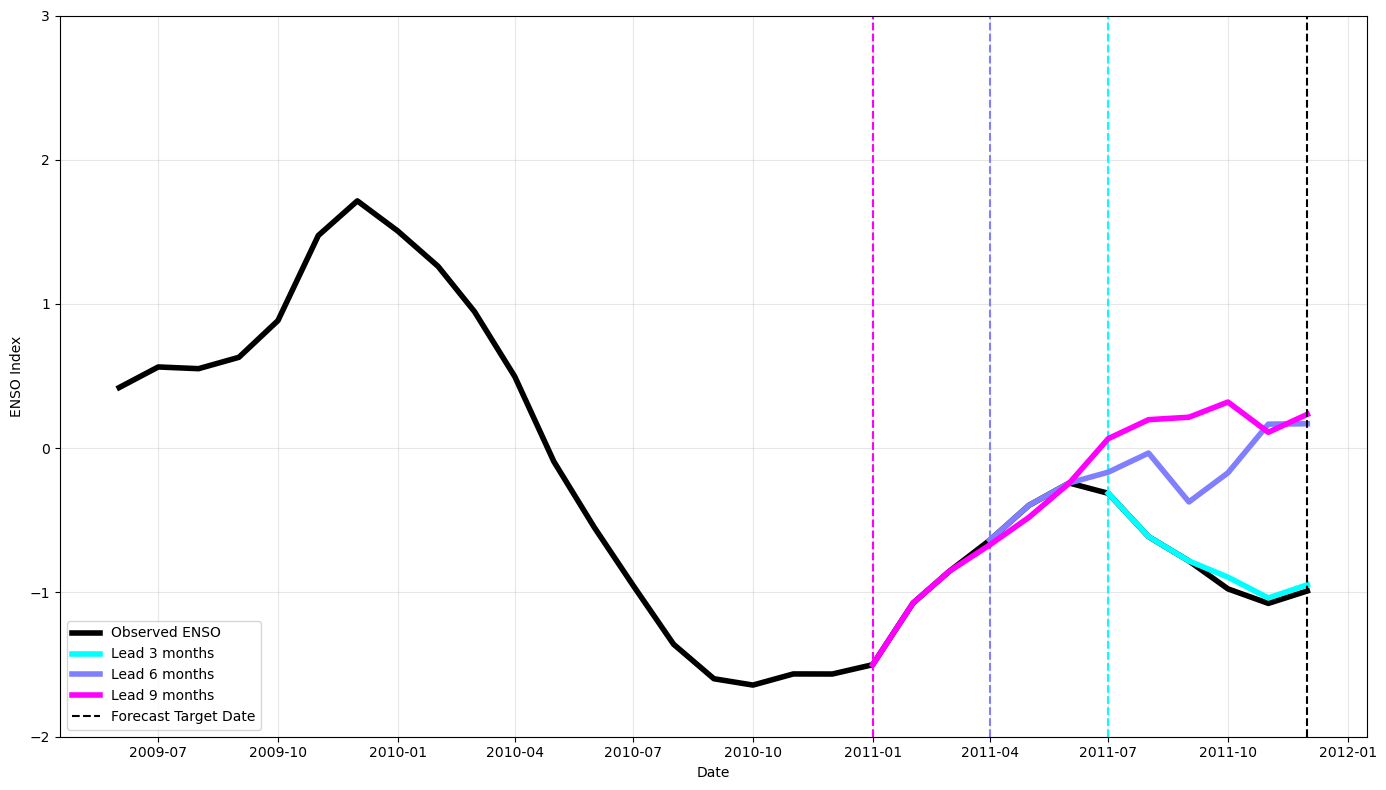

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


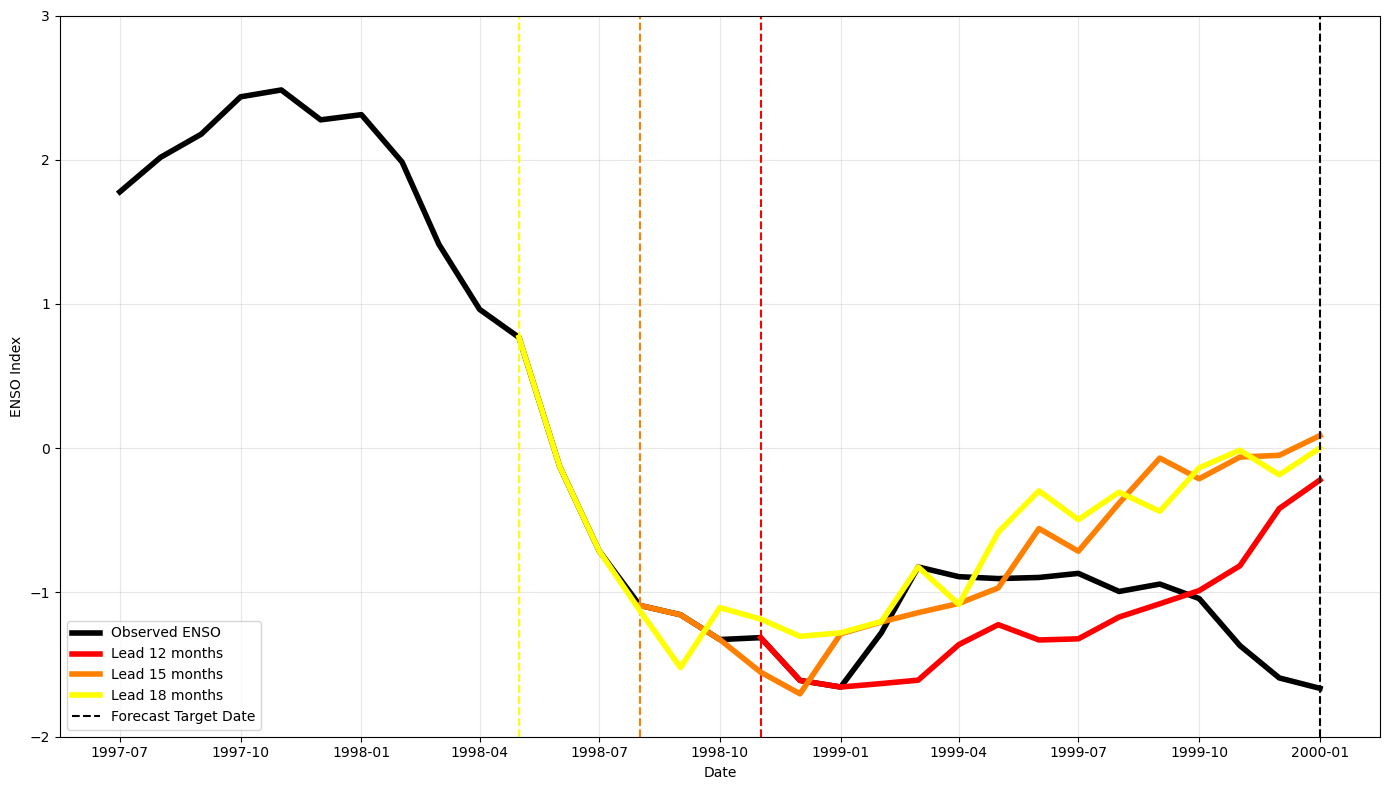

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


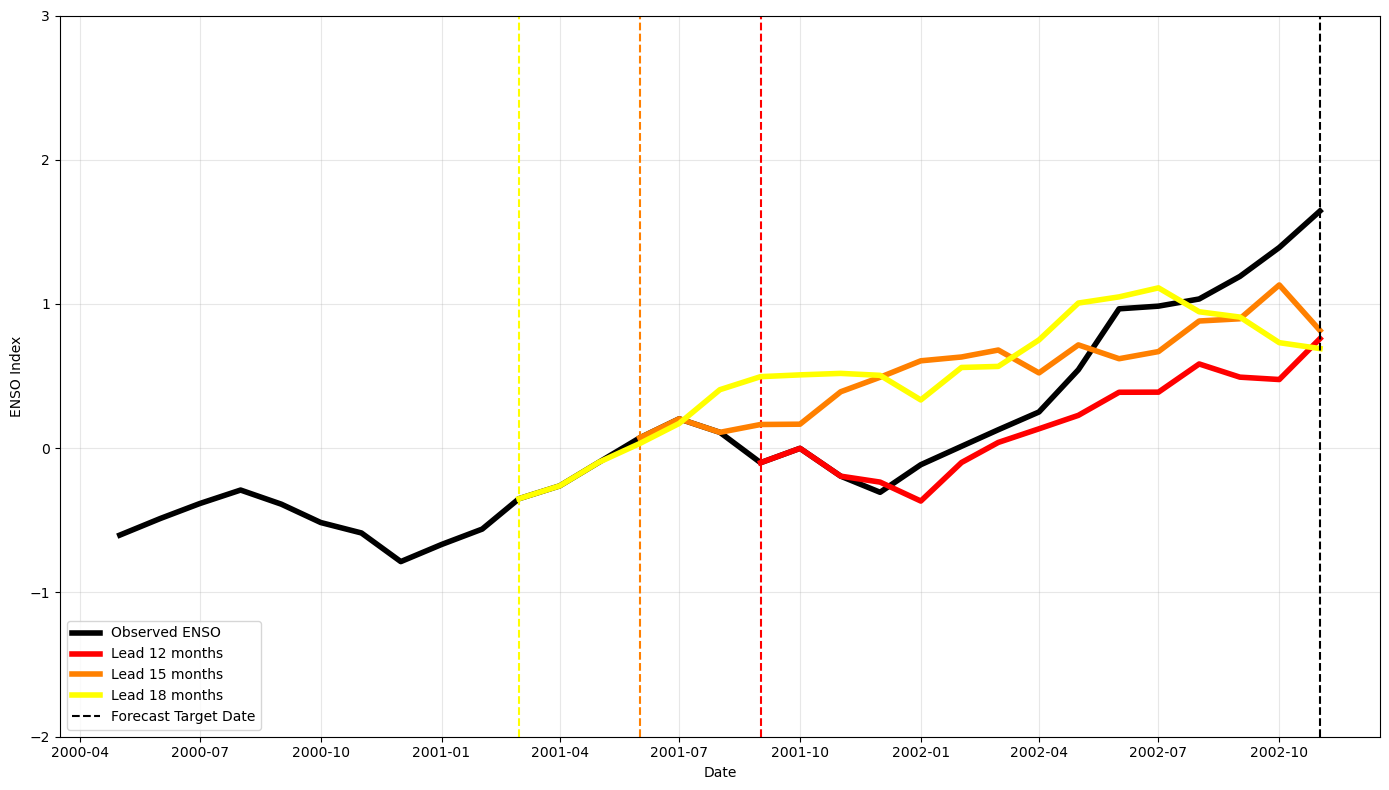

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


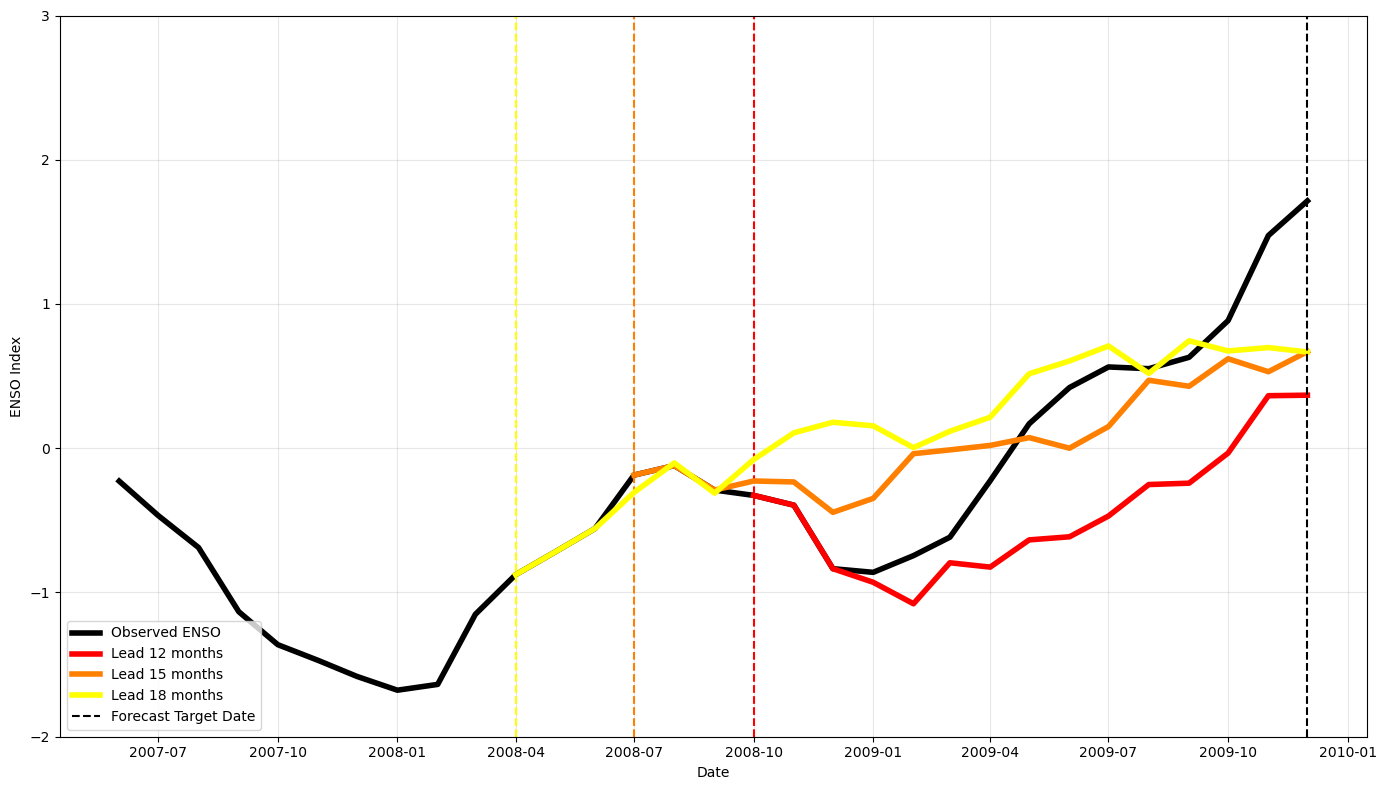

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


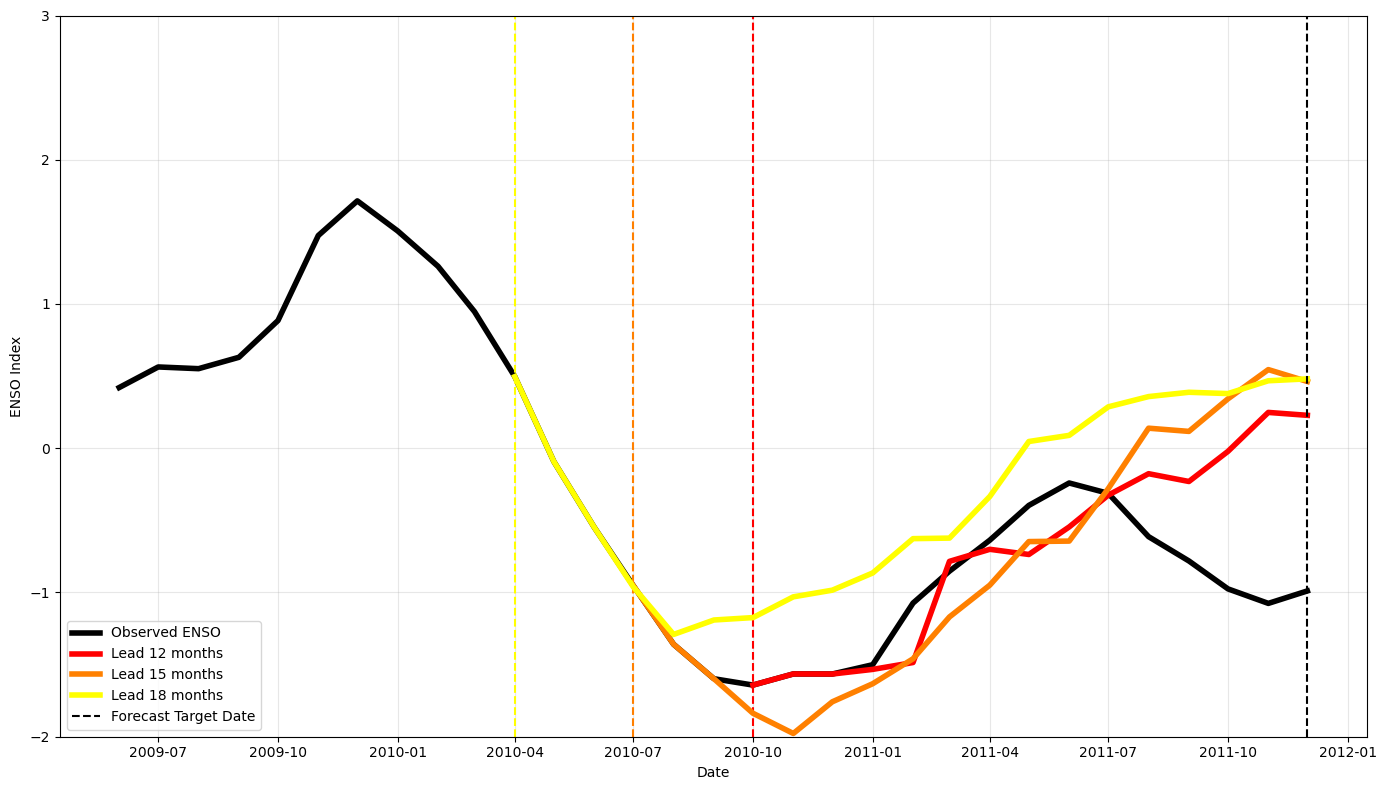

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


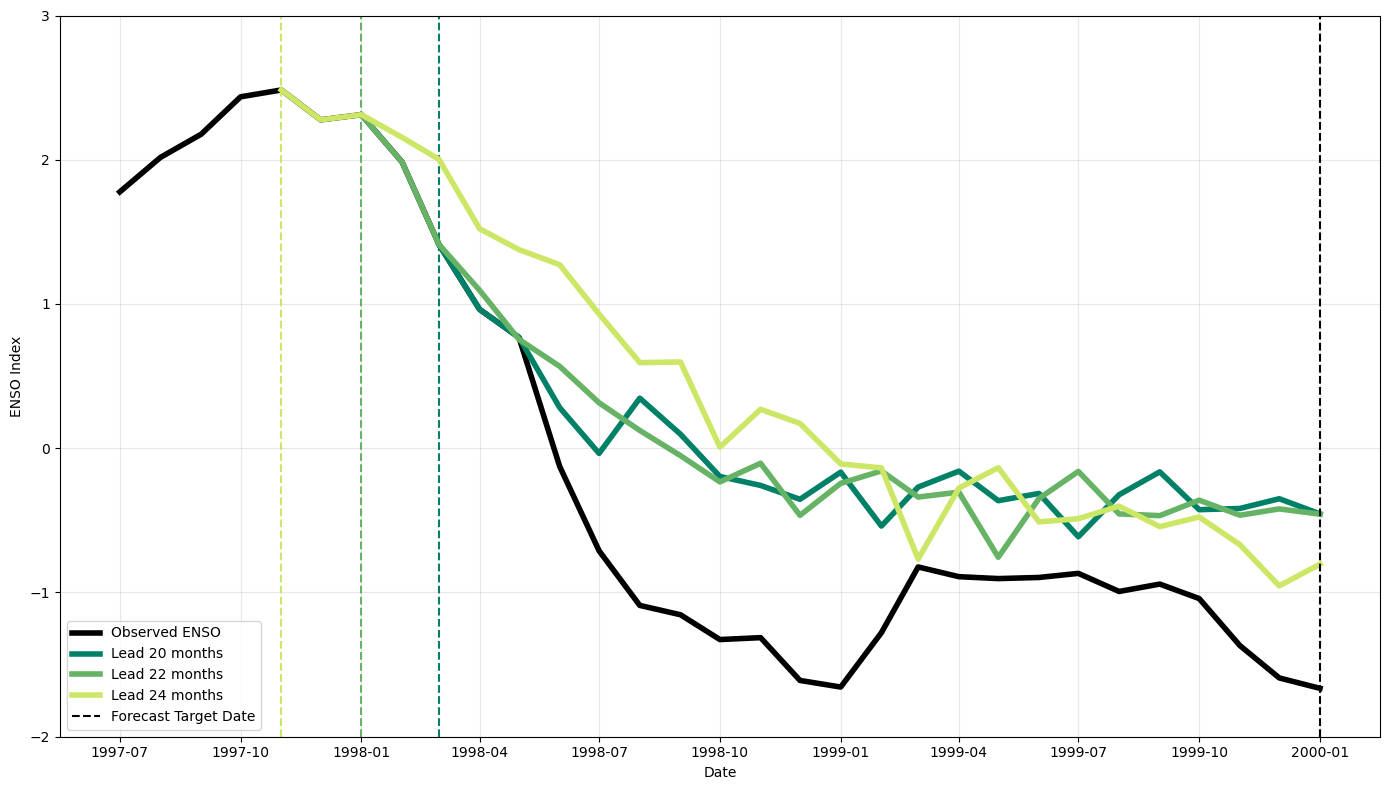

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


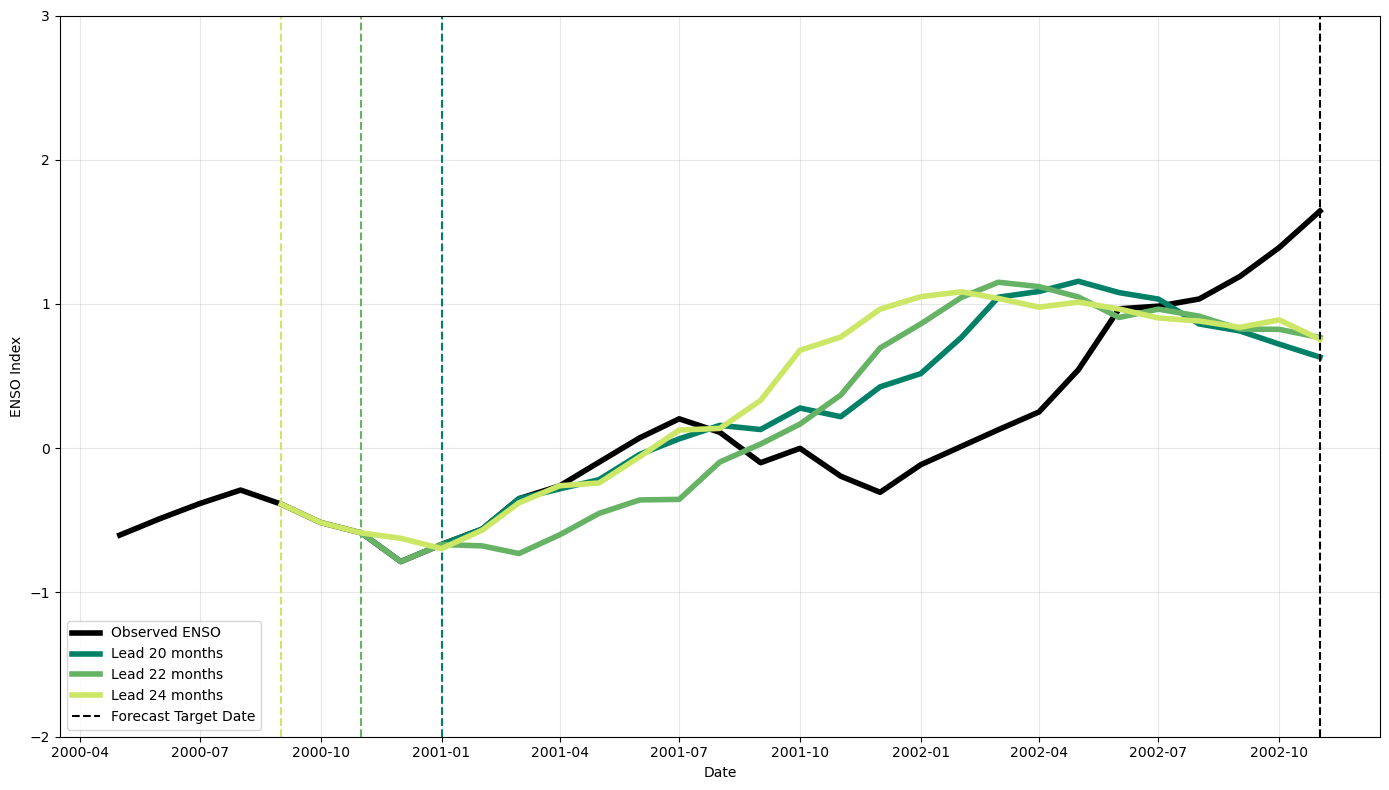

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


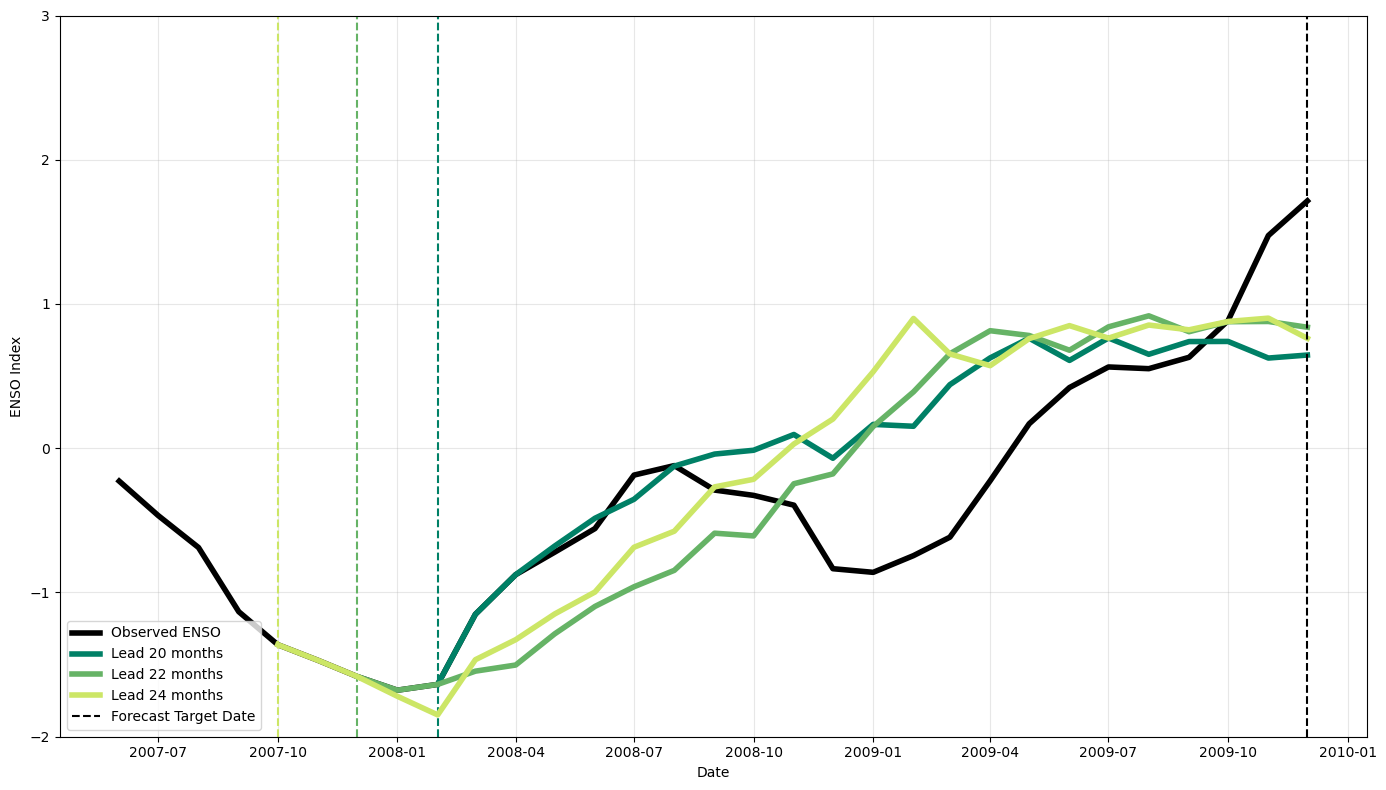

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_66795/1638372004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


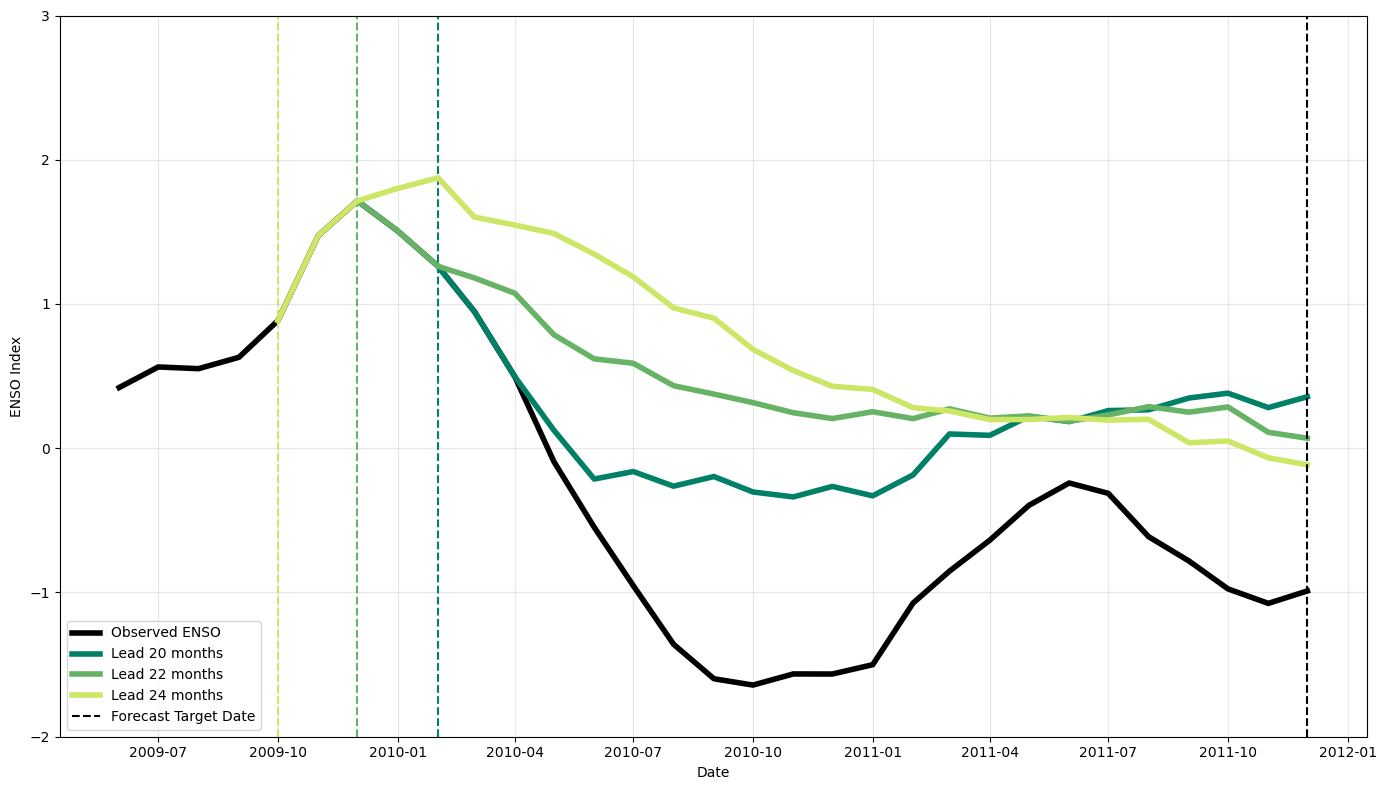

In [ ]:
leads_1 = [3,6,9]
leads_2 = [12,15,18]
leads_3 = [20,22,24]

# Plot commands for each forecast result
plot_forecasts_by_lags(forecast_data_dict=forecast_results_2000_la_nina, observed_data=data_final, lags=leads_1, plot_start_date='1997-07-01', plot_end_date='2000-01-01', colormap = 'cool', ls1 = 0, ls2 = 1, name = 'forecast_results_2000_la_nina')
plot_forecasts_by_lags(forecast_data_dict=forecast_results_2002_elnino, observed_data=data_final, lags=leads_1,plot_start_date='2000-05-01', plot_end_date='2002-11-01', colormap = 'cool', ls1 = 0, ls2 = 1, name = 'forecast_results_2002_elnino')

plot_forecasts_by_lags(forecast_data_dict=forecast_results_2009_elnino, observed_data=data_final, lags=leads_1, plot_start_date='2007-06-01', plot_end_date='2009-12-01', colormap = 'cool', ls1 = 0, ls2 = 1, name = 'forecast_results_2009_elnino')
plot_forecasts_by_lags(forecast_data_dict=forecast_results_2011_lanina, observed_data=data_final, lags=leads_1,plot_start_date='2009-06-01', plot_end_date='2011-12-01', colormap = 'cool', ls1 = 0, ls2 = 1, name = 'forecast_results_2011_lanina')
plot_forecasts_by_lags(forecast_data_dict=forecast_results_2000_la_nina, observed_data=data_final, lags=leads_2, plot_start_date='1997-07-01', plot_end_date='2000-01-01', colormap='autumn', ls1 = 0, ls2 = 1, name = 'forecast_results_2000_la_nina') 
plot_forecasts_by_lags(forecast_data_dict=forecast_results_2002_elnino, observed_data=data_final, lags=leads_2,plot_start_date='2000-05-01', plot_end_date='2002-11-01' ,colormap='autumn', ls1 = 0, ls2 = 1, name = 'forecast_results_2002_elnino')

plot_forecasts_by_lags(forecast_data_dict=forecast_results_2009_elnino, observed_data=data_final, lags=leads_2, plot_start_date='2007-06-01', plot_end_date='2009-12-01', colormap='autumn', ls1 = 0, ls2 = 1, name = 'forecast_results_2009_elnino')
plot_forecasts_by_lags(forecast_data_dict=forecast_results_2011_lanina, observed_data=data_final, lags=leads_2,plot_start_date='2009-06-01', plot_end_date='2011-12-01' ,  colormap='autumn', ls1 = 0, ls2 = 1, name ='forecast_results_2011_lanina')
plot_forecasts_by_lags(forecast_data_dict=forecast_results_2000_la_nina, observed_data=data_final, lags=leads_3, plot_start_date='1997-07-01', plot_end_date='2000-01-01', colormap= 'summer', ls1 = 0, ls2 = 0.8, name =  'forecast_results_2000_la_nina')
plot_forecasts_by_lags(forecast_data_dict=forecast_results_2002_elnino, observed_data=data_final, lags=leads_3,plot_start_date='2000-05-01', plot_end_date='2002-11-01', colormap= 'summer', ls1 = 0, ls2 = 0.8, name =  'forecast_results_2002_elnino')

plot_forecasts_by_lags(forecast_data_dict=forecast_results_2009_elnino, observed_data=data_final, lags=leads_3, plot_start_date='2007-06-01', plot_end_date='2009-12-01', colormap= 'summer', ls1 = 0, ls2 = 0.8, name = 'forecast_results_2009_elnino')
plot_forecasts_by_lags(forecast_data_dict=forecast_results_2011_lanina, observed_data=data_final, lags=leads_3,plot_start_date='2009-06-01', plot_end_date='2011-12-01', colormap='summer', ls1 = 0, ls2 = 0.8, name = 'forecast_results_2011_lanina')

